# BBO-Rietveld DSMO

In this notebook, you can see how to automate Rietveld refinement with black-box optimization.  
Run the following cells to run the optimization.

## Documentations
- [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/)
- [GSASIIscriptable: Scripting Interface](https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html)
- [Optuna](https://optuna.readthedocs.io/en/stable/)

In [1]:
# import packages
%matplotlib inline

import os
import sys
from multiprocessing import Process, Queue
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sys.path.append('/opt/conda/GSASII/')

In [2]:
# Configurations
RANDOM_SEED = 1024
STUDY_NAME = 'DSMO'
DATA_DIR = '/bbo_rietveld/data/' + STUDY_NAME
# all output files include GSAS project file (*.gpx) will be saved in WORK_DIR
WORK_DIR = '/bbo_rietveld/work/' + STUDY_NAME

In [3]:
# make directories
! rm -f $WORK_DIR/*
! mkdir -p $WORK_DIR

In [4]:
class ProjectDSMO:
    def __init__(self, trial_number):
        import GSASIIscriptable as G2sc
        import shutil
        
        # Create a project with a default project name
        shutil.copyfile(DATA_DIR+'/'+'DSMO_init.gpx', WORK_DIR+'/'+'DSMO_seed{0}_trial_{1}.gpx'.format(RANDOM_SEED, trial_number))
        self.gpx = G2sc.G2Project(gpxfile=os.path.join(WORK_DIR, 'DSMO_seed{0}_trial_{1}.gpx'.format(RANDOM_SEED, trial_number)))

        # Add two histograms to the project
        self.hist1 = self.gpx.histograms()[0]
        self.phase0 = self.gpx.phases()[0]
        self.hist1.data['Instrument Parameters'][0]['I(L2)/I(L1)'] = [0.5, 0.5, 0]

        # Set to use iso
        for val in self.phase0.data['Atoms']:
            val[9] = 'I'

    def refine_and_calc_Rwp(self, param_dict):
        self.gpx.do_refinements([param_dict])
        for hist in self.gpx.histograms():
            _, Rwp = hist.name, hist.get_wR()
        return Rwp

In the objective function, first, configurations for the following parameters are sampled.
Then, the crystal structure is refined by GSAS-II.
Finally, the calculated Rwp is returned.

| Parameter                                 | Parameter type   | Search space                                                                                                      |
|-------------------------------------------|------------------|-------------------------------------------------------------------------------------------------------------------|
| initial 2theta bound refinement           | categorical      | {True, False}                                                                                                      |
| initial 2theta lower bound (deg.)         | real             | [15, 80]                                                                                                          |
| initial 2theta upper bound (deg.)         | real/conditional | [l + 20, 100] (l is the initial 2theta lower bound)                                                                |
| background function                       | categorical      | {Chebyshev, cosine, Q^2 power series, Q^-2 power series, linear interpolate, inverse interpolate, log interpolate} |
| degree of background function             | initegral        | [1, 15]                                                                                                            |
| instrument zero position refinement       | categorical      | {True, False}                                                                                                      |
| sample shift X refinement                 | categorical      | {True, False}                                                                                                      |
| sample shift Y refinement                 | categorical      | {True, False}                                                                                                      |
| scale factor refinement                   | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Gaussian: U, V, W) | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Lorentzian: X, Y)  | categorical      | {True, False}                                                                                                      |
| peak shape refinement (SH/L)              | categorical      | {True, False}                                                                                                      |

In [5]:
def objective(trial):
    """
    objective function for Optuna.
    
    You can apply black-box optimization for other data analysis 
    by modifying this function for that task.
    
    Parameters
    ----------
    trial : optuna.trial object

    Returns
    -------
    Rwp : float
    
    """
    
    ### define search space ###
    # Limits (acute angle)
    limits_lb = trial.suggest_uniform('Limits lower bound', 15, 80)
    limits_ub = trial.suggest_uniform('Limits upper bound', limits_lb + 20, 100)
    limits_refine = trial.suggest_categorical('limits refine', [True, False])
    refdict0 = {'set': {'Limits': [limits_lb, limits_ub]}, 'refine': limits_refine}

    # Background
    background_type = trial.suggest_categorical(
        'Background type', ['chebyschev',
                            'cosine',
                            'Q^2 power series',
                            'Q^-2 power series',
                            'lin interpolate',
                            'inv interpolate',
                            'log interpolate'])
    no_coeffs = trial.suggest_int('Number of coefficietns', 1, 15 + 1)  # [1, 16)
    background_refine = trial.suggest_categorical('Background refine', [True, False])
    refdict0bg_h = {
        'set': {
            'Background': {
                'type': background_type,
                'no. coeffs': no_coeffs,
                'refine': background_refine
            }
        }
    }

    # Instrument parameters
    instrument_parameters1_refine = []
    for p in ['Zero']:
        if trial.suggest_categorical('Instrument_parameters refine %s' % (p), [True, False]):
            instrument_parameters1_refine.append(p)
    refdict1_h = {'set': {'Cell': True, 'Instrument Parameters': instrument_parameters1_refine}}

    sample_parameters1_refine =[]
    for p in ['DisplaceX', 'DisplaceY', 'Scale']:
        if trial.suggest_categorical('Sample_parameters refine %s' % (p), [True, False]):
            sample_parameters1_refine.append(p)
    refdict1_h2 = {"set": {'Sample Parameters':sample_parameters1_refine }}

    instrument_parameters2_refine = []
    for p in ['U', 'V', 'W', 'X', 'Y', 'SH/L']:
        if trial.suggest_categorical('Peakshape_parameters refine %s' % (p), [True, False]):
            instrument_parameters2_refine.append(p)
    refdict2_h = {'set': {'Instrument Parameters': instrument_parameters2_refine}}

    refdict3_h = {'set': {'Atoms': {'all': 'XU'}}}

    # Limits (wide angle)
    refdict_fin_h = {'set': {'Limits': [15, 100]}, 'refine': True}

    # Evaluate
    refine_params_list = [refdict0,
                          refdict0bg_h,
                          refdict1_h,
                          refdict1_h2,
                          refdict2_h,
                          refdict3_h,
                          refdict_fin_h]
    
    def evaluate(trial_number, refine_params_list, q):
        ERROR_PENALTY = 1e9      
        try:
            project = ProjectDSMO(trial_number)
            for params in refine_params_list:
                Rwp = project.refine_and_calc_Rwp(params)                    
            # validate Uiso >= 0
            phase_DSMO = project.gpx.phases()[0]
            u_iso_list = [atom.uiso for atom in phase_DSMO.atoms()]
            if min(u_iso_list) < 0:
                # Uiso < 0
                Rwp = ERROR_PENALTY
            q.put(Rwp)
            
        except Exception as e:
            # Refinement failed
            print(e, file=sys.stderr)
            q.put(ERROR_PENALTY)
            
    q = Queue()
    p = Process(target=evaluate, args=(trial.number, refine_params_list, q))
    p.start()
    Rwp = q.get()
    p.join()
    
    return Rwp

In [6]:
# Create Optuna study
study = optuna.create_study(study_name=STUDY_NAME + '_seed%s' % (RANDOM_SEED),
                            sampler=optuna.samplers.TPESampler(n_startup_trials=20, seed=RANDOM_SEED))

Run 200 refinements to find the best configuration. It may take abount an hour to complete.

In [7]:
# Optimize
study.optimize(objective, n_trials=200, n_jobs=1)

GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_0.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.2476e+05 on 2143 obs.
 Cycle: 0, Time: 0.39s, Chi**2: 70146 for 2143 obs., Lambda: 0.001,  Delta: 0.866
initial chi^2 70146 on 2143 obs.
 Cycle: 1, Time: 0.31s, Chi**2: 70143 for 2143 obs., Lambda: 0.001,  Delta: 4.45e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_0.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_0.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_0.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_0.gpx
 Hessian Levenberg-Marquardt SVD refinement on 3 variables:
initial chi^2 72822 on 2143 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 71392 for 2143 obs., Lambda: 0.001,  Delta: 0.0196
initial chi^2 71392 on 2143 obs.

[I 2020-01-12 13:56:25,495] Finished trial#0 resulted in value: 17.78673118556928. Current best value is 17.78673118556928 with parameters: {'Limits lower bound': 57.09992999302858, 'Limits upper bound': 99.92932076301099, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_1.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.8473e+05 on 1583 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 32963 for 1583 obs., Lambda: 0.001,  Delta: 0.884
initial chi^2 32963 on 1583 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 32962 for 1583 obs., Lambda: 0.001,  Delta: 3.39e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_1.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_1.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_1.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_1.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 32963 on 1583 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 32963 for 1583 obs., Lambda: 0.001,  Delta: 7.92e-09
converged
Found 0 SVD zeros
Re

[I 2020-01-12 13:56:33,944] Finished trial#1 resulted in value: 1000000000.0. Current best value is 17.78673118556928 with parameters: {'Limits lower bound': 57.09992999302858, 'Limits upper bound': 99.92932076301099, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_2.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.2964e+05 on 1087 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 30901 for 1087 obs., Lambda: 0.001,  Delta: 0.865
initial chi^2 30901 on 1087 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 30861 for 1087 obs., Lambda: 0.001,  Delta: 0.0013
initial chi^2 30861 on 1087 obs.
 Cycle: 2, Time: 0.20s, Chi**2: 30861 for 1087 obs., Lambda: 0.001,  Delta: -1.65e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_2.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_2.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_2.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_2.gpx
 Hessian Levenberg-Marquardt SVD refinement on 3 variables:
initial chi^2 62517 on 1087 obs

[I 2020-01-12 13:56:42,166] Finished trial#2 resulted in value: 1000000000.0. Current best value is 17.78673118556928 with parameters: {'Limits lower bound': 57.09992999302858, 'Limits upper bound': 99.92932076301099, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_3.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.8134e+05 on 1063 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 15990 for 1063 obs., Lambda: 0.001,  Delta: 0.912
initial chi^2 15990 on 1063 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 15990 for 1063 obs., Lambda: 0.001,  Delta: 5.7e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_3.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_3.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_3.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_3.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gpx file saved as /bbo_rietveld/work/DSMO/

[I 2020-01-12 13:56:44,674] Finished trial#3 resulted in value: 28.360749474682915. Current best value is 17.78673118556928 with parameters: {'Limits lower bound': 57.09992999302858, 'Limits upper bound': 99.92932076301099, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_4.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 6.5222e+05 on 1132 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 1.3449e+05 for 1132 obs., Lambda: 0.001,  Delta: 0.794
initial chi^2 1.3449e+05 on 1132 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.3449e+05 for 1132 obs., Lambda: 0.001,  Delta: 2.24e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_4.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_4.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_4.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_4.gpx
 Hessian Levenberg-Marquardt SVD refinement on 2 variables:
initial chi^2 1.3632e+05 on 1132 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.3565e+05 for 1132 obs., Lambda: 0.001,  Delta: 0.00492
initia

[I 2020-01-12 13:56:50,880] Finished trial#4 resulted in value: 1000000000.0. Current best value is 17.78673118556928 with parameters: {'Limits lower bound': 57.09992999302858, 'Limits upper bound': 99.92932076301099, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_5.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.7457e+05 on 1033 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 15326 for 1033 obs., Lambda: 0.001,  Delta: 0.912
initial chi^2 15326 on 1033 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 15325 for 1033 obs., Lambda: 0.001,  Delta: 9.25e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_5.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_5.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_5.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_5.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 16679 on 1033 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 15083 for 1033 obs., Lambda: 0.001,  Delta: 0.0957
initial chi^2 15083 on 1033 obs

[I 2020-01-12 13:56:58,929] Finished trial#5 resulted in value: 1000000000.0. Current best value is 17.78673118556928 with parameters: {'Limits lower bound': 57.09992999302858, 'Limits upper bound': 99.92932076301099, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_6.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.2988e+05 on 1252 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 48846 for 1252 obs., Lambda: 0.001,  Delta: 0.852
initial chi^2 48846 on 1252 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 48842 for 1252 obs., Lambda: 0.001,  Delta: 8.53e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_6.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_6.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_6.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_6.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 62985 on 1252 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 46320 for 1252 obs., Lambda: 0.001,  Delta: 0.265
initial chi^2 46320 on 1252 obs.

[I 2020-01-12 13:57:06,470] Finished trial#6 resulted in value: 9.721850683370082. Current best value is 9.721850683370082 with parameters: {'Limits lower bound': 53.63906871063119, 'Limits upper bound': 78.6436412953652, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_7.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.3625e+05 on 1738 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 62219 for 1738 obs., Lambda: 0.001,  Delta: 0.857
initial chi^2 62219 on 1738 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 62217 for 1738 obs., Lambda: 0.001,  Delta: 2.7e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_7.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_7.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_7.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_7.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 2.0512e+05 on 1738 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 56656 for 1738 obs., Lambda: 0.001,  Delta: 0.724
initial chi^2 56656 on 1738 

[I 2020-01-12 13:57:15,887] Finished trial#7 resulted in value: 9.782234457803876. Current best value is 9.721850683370082 with parameters: {'Limits lower bound': 53.63906871063119, 'Limits upper bound': 78.6436412953652, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_8.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.8498e+05 on 1086 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 16381 for 1086 obs., Lambda: 0.001,  Delta: 0.911
initial chi^2 16381 on 1086 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 16380 for 1086 obs., Lambda: 0.001,  Delta: 6.42e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_8.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_8.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_8.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_8.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.0276e+05 on 1086 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 93881 for 1086 obs., Lambda: 0.001,  Delta: 0.0864
initial chi^2 93881 on 1086

[I 2020-01-12 13:57:24,056] Finished trial#8 resulted in value: 1000000000.0. Current best value is 9.721850683370082 with parameters: {'Limits lower bound': 53.63906871063119, 'Limits upper bound': 78.6436412953652, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_9.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.7367e+05 on 2414 obs.
 Cycle: 0, Time: 0.36s, Chi**2: 74401 for 2414 obs., Lambda: 0.001,  Delta: 0.87
initial chi^2 74401 on 2414 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 74397 for 2414 obs., Lambda: 0.001,  Delta: 5.29e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_9.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_9.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_9.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_9.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 90493 on 2414 obs.
 Cycle: 0, Time: 0.33s, Chi**2: 73348 for 2414 obs., Lambda: 0.001,  Delta: 0.189
initial chi^2 73348 on 2414 obs.


[I 2020-01-12 13:57:36,587] Finished trial#9 resulted in value: 9.620295980284146. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_10.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.1635e+05 on 1015 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 19988 for 1015 obs., Lambda: 0.001,  Delta: 0.908
initial chi^2 19988 on 1015 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 19902 for 1015 obs., Lambda: 0.001,  Delta: 0.00433
initial chi^2 19902 on 1015 obs.
 Cycle: 2, Time: 0.18s, Chi**2: 19902 for 1015 obs., Lambda: 0.001,  Delta: -1.88e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_10.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_10.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_10.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_10.gpx
 Hessian Levenberg-Marquardt SVD refinement on 5 variables:
initial chi^2 75606 on 10

[I 2020-01-12 13:57:45,514] Finished trial#10 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_11.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.8628e+05 on 1016 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 15012 for 1016 obs., Lambda: 0.001,  Delta: 0.919
initial chi^2 15012 on 1016 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 15011 for 1016 obs., Lambda: 0.001,  Delta: 0.000119
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_11.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_11.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_11.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_11.gpx
 Hessian Levenberg-Marquardt SVD refinement on 3 variables:
initial chi^2 16971 on 1016 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 15906 for 1016 obs., Lambda: 0.001,  Delta: 0.0628
initial chi^2 15906 on 1016

[I 2020-01-12 13:57:53,599] Finished trial#11 resulted in value: 16.975983052947182. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_12.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.2508e+05 on 1683 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 61408 for 1683 obs., Lambda: 0.001,  Delta: 0.856
initial chi^2 61408 on 1683 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 61406 for 1683 obs., Lambda: 0.001,  Delta: 4.18e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_12.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_12.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_12.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_12.gpx
 Hessian Levenberg-Marquardt SVD refinement on 5 variables:
initial chi^2 1.5924e+05 on 1683 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 63409 for 1683 obs., Lambda: 0.001,  Delta: 0.602
initial chi^2 63409 on 

[I 2020-01-12 13:58:02,891] Finished trial#12 resulted in value: 14.677792188461428. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_13.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.5309e+05 on 2175 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 1.8464e+05 for 2175 obs., Lambda: 0.001,  Delta: 0.806
initial chi^2 1.8464e+05 on 2175 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.8463e+05 for 2175 obs., Lambda: 0.001,  Delta: 8.51e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_13.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_13.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_13.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_13.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 1.9104e+05 on 2175 obs.
new chi^2 2.3269e+05 on 2175 obs., 0 SVD zeros ; matrix modification needed; lambda now 1

[I 2020-01-12 13:58:10,900] Finished trial#13 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_14.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8783e+05 on 2080 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 65910 for 2080 obs., Lambda: 0.001,  Delta: 0.865
initial chi^2 65910 on 2080 obs.
 Cycle: 1, Time: 0.27s, Chi**2: 65905 for 2080 obs., Lambda: 0.001,  Delta: 6.69e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_14.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_14.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_14.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_14.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 68309 on 2080 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 68297 for 2080 obs., Lambda: 0.001,  Delta: 0.000171
converged
Found 0 SVD zer

[I 2020-01-12 13:58:18,926] Finished trial#14 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_15.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.6369e+05 on 2234 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 1.8384e+05 for 2234 obs., Lambda: 0.001,  Delta: 0.809
initial chi^2 1.8384e+05 on 2234 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.8384e+05 for 2234 obs., Lambda: 0.001,  Delta: 1.71e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_15.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_15.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_15.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_15.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.8384e+05 on 2234 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 1.8384e+05 for 2234 obs., Lambda: 0.001,  Delta: 1.26e-08


[I 2020-01-12 13:58:27,867] Finished trial#15 resulted in value: 16.30069062819214. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_16.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.3033e+05 on 1232 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 23918 for 1232 obs., Lambda: 0.001,  Delta: 0.896
initial chi^2 23918 on 1232 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 22312 for 1232 obs., Lambda: 0.001,  Delta: 0.0671
initial chi^2 22312 on 1232 obs.
new chi^2 22358 on 1232 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-04
new chi^2 22358 on 1232 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-03
 Cycle: 2, Time: 0.34s, Chi**2: 22358 for 1232 obs., Lambda: 0.001,  Delta: -0.00206
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_16.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_16.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_16.lst
 ***** Re

[I 2020-01-12 13:58:39,954] Finished trial#16 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_17.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.1631e+05 on 1065 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 29495 for 1065 obs., Lambda: 0.001,  Delta: 0.864
initial chi^2 29495 on 1065 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 29494 for 1065 obs., Lambda: 0.001,  Delta: 3.87e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_17.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_17.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_17.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_17.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.1101e+05 on 1065 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 1.0594e+05 for 1065 obs., Lambda: 0.001,  Delta: 0.0457
initial chi^2 1.0

[I 2020-01-12 13:58:47,726] Finished trial#17 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_18.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.6951e+05 on 2062 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 64396 for 2062 obs., Lambda: 0.001,  Delta: 0.863
initial chi^2 64396 on 2062 obs.
 Cycle: 1, Time: 0.28s, Chi**2: 64395 for 2062 obs., Lambda: 0.001,  Delta: 1.64e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_18.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_18.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_18.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_18.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 73259 on 2062 obs.
 Cycle: 0, Time: 0.30s, Chi**2: 63612 for 2062 obs., Lambda: 0.001,  Delta: 0.132
initial chi^2 63612 on 2062

[I 2020-01-12 13:59:44,607] Finished trial#18 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_19.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.1859e+05 on 2337 obs.
 Cycle: 0, Time: 0.39s, Chi**2: 67785 for 2337 obs., Lambda: 0.001,  Delta: 0.869
initial chi^2 67785 on 2337 obs.
 Cycle: 1, Time: 0.37s, Chi**2: 67784 for 2337 obs., Lambda: 0.001,  Delta: 1.67e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_19.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_19.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_19.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_19.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 4.233e+08 on 2337 obs.
new chi^2 3.6145e+21 on 2337 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new chi^2

[I 2020-01-12 13:59:53,272] Finished trial#19 resulted in value: 100.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_20.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.0816e+05 on 1257 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 59813 for 1257 obs., Lambda: 0.001,  Delta: 0.853
initial chi^2 59813 on 1257 obs.
 Cycle: 1, Time: 0.14s, Chi**2: 59812 for 1257 obs., Lambda: 0.001,  Delta: 1.67e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_20.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_20.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_20.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_20.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 63862 on 1257 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 57540 for 1257 obs., Lambda: 0.001,  Delta: 0.099
initial chi^2 57540 on 1257

[I 2020-01-12 14:00:00,812] Finished trial#20 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_21.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.4451e+05 on 1751 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 88156 for 1751 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 88156 on 1751 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 88151 for 1751 obs., Lambda: 0.001,  Delta: 5.39e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_21.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_21.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_21.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_21.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.1092e+05 on 1751 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 87699 for 1751 obs., Lambda: 0.001,  Delta: 0.209
initial chi^2 87699 on

[I 2020-01-12 14:00:09,361] Finished trial#21 resulted in value: 9.901240330549141. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_22.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.9811e+05 on 2136 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 92224 for 2136 obs., Lambda: 0.001,  Delta: 0.846
initial chi^2 92224 on 2136 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 92173 for 2136 obs., Lambda: 0.001,  Delta: 0.000559
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_22.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_22.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_22.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_22.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 97393 on 2136 obs.
new chi^2 1.0881e+05 on 2136 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new chi^2 1.0

[I 2020-01-12 14:00:17,631] Finished trial#22 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_23.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.857e+05 on 1510 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 68985 for 1510 obs., Lambda: 0.001,  Delta: 0.858
initial chi^2 68985 on 1510 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 68984 for 1510 obs., Lambda: 0.001,  Delta: 1.67e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_23.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_23.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_23.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_23.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 75294 on 1510 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 68219 for 1510 obs., Lambda: 0.001,  Delta: 0.094
initial chi^2 68219 on 1510 

[I 2020-01-12 14:00:25,154] Finished trial#23 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_24.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.1027e+05 on 2005 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 1.6471e+05 for 2005 obs., Lambda: 0.001,  Delta: 0.819
initial chi^2 1.6471e+05 on 2005 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 1.6471e+05 for 2005 obs., Lambda: 0.001,  Delta: 8.46e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_24.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_24.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_24.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_24.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 1.8307e+05 on 2005 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 1.5826e+05 for 2005 obs., Lambda: 0.001,  Delta: 0.136
in

[I 2020-01-12 14:00:33,291] Finished trial#24 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_25.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.0806e+05 on 1050 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 28526 for 1050 obs., Lambda: 0.001,  Delta: 0.863
initial chi^2 28526 on 1050 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 28491 for 1050 obs., Lambda: 0.001,  Delta: 0.00123
initial chi^2 28491 on 1050 obs.
 Cycle: 2, Time: 0.19s, Chi**2: 28491 for 1050 obs., Lambda: 0.001,  Delta: -8.91e-07
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_25.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_25.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_25.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_25.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 1.1116e+05

[I 2020-01-12 14:00:44,678] Finished trial#25 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_26.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8399e+05 on 1572 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 77879 for 1572 obs., Lambda: 0.001,  Delta: 0.839
initial chi^2 77879 on 1572 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 77877 for 1572 obs., Lambda: 0.001,  Delta: 3.1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_26.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_26.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_26.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_26.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.1144e+05 on 1572 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 75809 for 1572 obs., Lambda: 0.001,  Delta: 0.32
initial chi^2 75809 on 1

[I 2020-01-12 14:00:53,084] Finished trial#26 resulted in value: 9.909688226423476. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_27.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.0433e+05 on 1488 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 59324 for 1488 obs., Lambda: 0.001,  Delta: 0.853
initial chi^2 59324 on 1488 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 59303 for 1488 obs., Lambda: 0.001,  Delta: 0.000351
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_27.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_27.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_27.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_27.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.8382e+05 on 1488 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 57362 for 1488 obs., Lambda: 0.001,  Delta: 0.688
initial chi^2 57362 on

[I 2020-01-12 14:01:01,629] Finished trial#27 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_28.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.4788e+05 on 1369 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 30483 for 1369 obs., Lambda: 0.001,  Delta: 0.877
initial chi^2 30483 on 1369 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 30483 for 1369 obs., Lambda: 0.001,  Delta: 1.89e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_28.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_28.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_28.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_28.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 30483 on 1369 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 29604 for 1369 obs., Lambda: 0.001,  Delta: 0.0288
initial chi^2 29604 on 136

[I 2020-01-12 14:01:12,043] Finished trial#28 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_29.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.9737e+05 on 1506 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 61636 for 1506 obs., Lambda: 0.001,  Delta: 0.845
initial chi^2 61636 on 1506 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 61476 for 1506 obs., Lambda: 0.001,  Delta: 0.00259
initial chi^2 61476 on 1506 obs.
 Cycle: 2, Time: 0.19s, Chi**2: 61477 for 1506 obs., Lambda: 0.001,  Delta: -6.87e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_29.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_29.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_29.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_29.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 74117 on 1

[I 2020-01-12 14:01:21,464] Finished trial#29 resulted in value: 9.678145897200055. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_30.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.6579e+05 on 1308 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 55073 for 1308 obs., Lambda: 0.001,  Delta: 0.849
initial chi^2 55073 on 1308 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 55071 for 1308 obs., Lambda: 0.001,  Delta: 2.88e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_30.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_30.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_30.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_30.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 60759 on 1308 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 54735 for 1308 obs., Lambda: 0.001,  Delta: 0.0991
initial chi^2 54735 on 1308

[I 2020-01-12 14:01:29,064] Finished trial#30 resulted in value: 11.414536807867147. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_31.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.2027e+05 on 1610 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 60887 for 1610 obs., Lambda: 0.001,  Delta: 0.855
initial chi^2 60887 on 1610 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 60882 for 1610 obs., Lambda: 0.001,  Delta: 8.46e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_31.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_31.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_31.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_31.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 71937 on 1610 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 59026 for 1610 obs., Lambda: 0.001,  Delta: 0.179
initial chi^2 59026 on 1610

[I 2020-01-12 14:01:38,129] Finished trial#31 resulted in value: 9.709105657026514. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_32.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.2295e+05 on 1137 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 30345 for 1137 obs., Lambda: 0.001,  Delta: 0.864
initial chi^2 30345 on 1137 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 30344 for 1137 obs., Lambda: 0.001,  Delta: 2.29e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_32.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_32.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_32.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_32.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 33217 on 1137 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 28125 for 1137 obs., Lambda: 0.001,  Delta: 0.153
initial chi^2 28125 on 1137

[I 2020-01-12 14:01:46,774] Finished trial#32 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_33.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.3153e+05 on 1222 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 48503 for 1222 obs., Lambda: 0.001,  Delta: 0.854
initial chi^2 48503 on 1222 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 48502 for 1222 obs., Lambda: 0.001,  Delta: 2.43e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_33.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_33.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_33.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_33.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 60427 on 1222 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 46582 for 1222 obs., Lambda: 0.001,  Delta: 0.229
initial chi^2 46582 on 1222

[I 2020-01-12 14:01:55,015] Finished trial#33 resulted in value: 9.64625756195022. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_34.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.602e+05 on 1351 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 77292 for 1351 obs., Lambda: 0.001,  Delta: 0.832
initial chi^2 77292 on 1351 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 77289 for 1351 obs., Lambda: 0.001,  Delta: 2.98e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_34.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_34.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_34.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_34.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 87927 on 1351 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 73580 for 1351 obs., Lambda: 0.001,  Delta: 0.163
initial chi^2 73580 on 1351 

[I 2020-01-12 14:02:02,785] Finished trial#34 resulted in value: 9.854485654350642. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_35.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.6627e+05 on 1804 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 88548 for 1804 obs., Lambda: 0.001,  Delta: 0.844
initial chi^2 88548 on 1804 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 88546 for 1804 obs., Lambda: 0.001,  Delta: 1.99e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_35.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_35.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_35.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_35.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 94762 on 1804 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 85928 for 1804 obs., Lambda: 0.001,  Delta: 0.0932
initial chi^2 85928 on 180

[I 2020-01-12 14:02:11,064] Finished trial#35 resulted in value: 9.761937791894416. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_36.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.3659e+05 on 1144 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 30758 for 1144 obs., Lambda: 0.001,  Delta: 0.87
initial chi^2 30758 on 1144 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 30756 for 1144 obs., Lambda: 0.001,  Delta: 6.34e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_36.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_36.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_36.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_36.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 31145 on 1144 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 28364 for 1144 obs., Lambda: 0.001,  Delta: 0.0893
initial chi^2 28364 on 1144

[I 2020-01-12 14:02:37,914] Finished trial#36 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_37.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.5764e+05 on 1389 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 34722 for 1389 obs., Lambda: 0.001,  Delta: 0.865
initial chi^2 34722 on 1389 obs.
 Cycle: 1, Time: 0.26s, Chi**2: 34721 for 1389 obs., Lambda: 0.001,  Delta: 1.72e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_37.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_37.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_37.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_37.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gpx file saved as /bbo_rietveld/work

[I 2020-01-12 14:02:40,923] Finished trial#37 resulted in value: 35.157689542412264. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_38.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.6462e+05 on 1405 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 51979 for 1405 obs., Lambda: 0.001,  Delta: 0.857
initial chi^2 51979 on 1405 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 51978 for 1405 obs., Lambda: 0.001,  Delta: 2.33e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_38.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_38.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_38.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_38.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 62987 on 1405 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 49691 for 1405 obs., Lambda: 0.001,  Delta: 0.211
initial chi^2 49691 on 1405

[I 2020-01-12 14:02:50,531] Finished trial#38 resulted in value: 9.649344818994168. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_39.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.0635e+05 on 1706 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 79833 for 1706 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 79833 on 1706 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 79832 for 1706 obs., Lambda: 0.001,  Delta: 1.8e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_39.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_39.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_39.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_39.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 96012 on 1706 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 77365 for 1706 obs., Lambda: 0.001,  Delta: 0.194
initial chi^2 77365 on 1706 

[I 2020-01-12 14:03:00,702] Finished trial#39 resulted in value: 9.962920511014026. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_40.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.4133e+05 on 1218 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 50462 for 1218 obs., Lambda: 0.001,  Delta: 0.852
initial chi^2 50462 on 1218 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 50461 for 1218 obs., Lambda: 0.001,  Delta: 2.65e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_40.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_40.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_40.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_40.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 5.4621e+06 on 1218 obs.
new chi^2 6.6643e+18 on 1218 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new chi^

[I 2020-01-12 14:03:06,032] Finished trial#40 resulted in value: 100.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_41.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.4121e+05 on 1305 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 48930 for 1305 obs., Lambda: 0.001,  Delta: 0.857
initial chi^2 48930 on 1305 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 48929 for 1305 obs., Lambda: 0.001,  Delta: 1.75e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_41.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_41.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_41.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_41.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 56593 on 1305 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 47731 for 1305 obs., Lambda: 0.001,  Delta: 0.157
initial chi^2 47731 on 1305

[I 2020-01-12 14:03:16,070] Finished trial#41 resulted in value: 9.649665337620428. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_42.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.8952e+05 on 1011 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 44013 for 1011 obs., Lambda: 0.001,  Delta: 0.848
initial chi^2 44013 on 1011 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 44011 for 1011 obs., Lambda: 0.001,  Delta: 3.56e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_42.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_42.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_42.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_42.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 63326 on 1011 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 41573 for 1011 obs., Lambda: 0.001,  Delta: 0.344
initial chi^2 41573 on 1011

[I 2020-01-12 14:03:26,774] Finished trial#42 resulted in value: 9.93684881908675. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_43.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.5112e+05 on 1309 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 50537 for 1309 obs., Lambda: 0.001,  Delta: 0.856
initial chi^2 50537 on 1309 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 50520 for 1309 obs., Lambda: 0.001,  Delta: 0.000329
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_43.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_43.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_43.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_43.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 59204 on 1309 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 48074 for 1309 obs., Lambda: 0.001,  Delta: 0.188
initial chi^2 48074 on 1309

[I 2020-01-12 14:03:45,558] Finished trial#43 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_44.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.6886e+05 on 1318 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 63111 for 1318 obs., Lambda: 0.001,  Delta: 0.829
initial chi^2 63111 on 1318 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 61920 for 1318 obs., Lambda: 0.001,  Delta: 0.0189
initial chi^2 61920 on 1318 obs.
 Cycle: 2, Time: 0.18s, Chi**2: 61951 for 1318 obs., Lambda: 0.001,  Delta: -0.000499
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_44.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_44.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_44.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_44.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 75751 on 13

[I 2020-01-12 14:03:55,881] Finished trial#44 resulted in value: 9.956672140020013. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_45.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.6807e+05 on 1432 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 32351 for 1432 obs., Lambda: 0.001,  Delta: 0.879
initial chi^2 32351 on 1432 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 32350 for 1432 obs., Lambda: 0.001,  Delta: 2.39e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_45.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_45.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_45.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_45.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 32355 on 1432 obs.
new chi^2 32700 on 1432 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
 Cycle: 0, Time: 0

/opt/conda/GSASII/GSASIIstrMath.py:811: RuntimeWarning: overflow encountered in exp
  Tiso = np.repeat(np.where(biso<1.,np.exp(biso),1.0),len(SGT)*len(TwinLaw),axis=1).T


 Cycle: 0, Time: 1.42s, Chi**2: 7.3245e+17 for 4251 obs., Lambda: 0.001,  Delta: 0.000186
converged


/opt/conda/GSASII/GSASIIstrMath.py:923: RuntimeWarning: overflow encountered in exp
  Tiso = np.repeat(np.where(biso<1.,np.exp(biso),1.0),len(SGT),axis=1).T


Found 12 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_45.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_45.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_45.lst
 ***** Refinement successful *****


[I 2020-01-12 14:04:05,202] Finished trial#45 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_46.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.1275e+05 on 1138 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 47900 for 1138 obs., Lambda: 0.001,  Delta: 0.847
initial chi^2 47900 on 1138 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 47899 for 1138 obs., Lambda: 0.001,  Delta: 3e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_46.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_46.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_46.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_46.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gpx file saved as /bbo_rietveld/work/DS

[I 2020-01-12 14:04:07,877] Finished trial#46 resulted in value: 37.354232365526535. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_47.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.445e+05 on 1237 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 76585 for 1237 obs., Lambda: 0.001,  Delta: 0.828
initial chi^2 76585 on 1237 obs.
 Cycle: 1, Time: 0.12s, Chi**2: 76567 for 1237 obs., Lambda: 0.001,  Delta: 0.000227
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_47.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_47.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_47.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_47.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 87344 on 1237 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 72703 for 1237 obs., Lambda: 0.001,  Delta: 0.168
initial chi^2 72703 on 1237 

[I 2020-01-12 14:04:15,923] Finished trial#47 resulted in value: 9.998832078672978. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_48.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.5563e+05 on 1208 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 53460 for 1208 obs., Lambda: 0.001,  Delta: 0.85
initial chi^2 53460 on 1208 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 53457 for 1208 obs., Lambda: 0.001,  Delta: 4.5e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_48.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_48.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_48.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_48.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 69723 on 1208 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 69493 for 1208 obs., Lambda: 0.001,  Delta: 0.0033
initial chi^2 69493 on 1208 o

[I 2020-01-12 14:04:24,039] Finished trial#48 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_49.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.2656e+05 on 1194 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 47744 for 1194 obs., Lambda: 0.001,  Delta: 0.854
initial chi^2 47744 on 1194 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 47743 for 1194 obs., Lambda: 0.001,  Delta: 2.02e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_49.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_49.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_49.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_49.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 50221 on 1194 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 45767 for 1194 obs., Lambda: 0.001,  Delta: 0.0887
initial chi^2 45767 on 119

[I 2020-01-12 14:04:31,339] Finished trial#49 resulted in value: 9.939916562002352. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_50.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.835e+05 on 1476 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 69194 for 1476 obs., Lambda: 0.001,  Delta: 0.857
initial chi^2 69194 on 1476 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 69193 for 1476 obs., Lambda: 0.001,  Delta: 2.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_50.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_50.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_50.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_50.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 69193 on 1476 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 67983 for 1476 obs., Lambda: 0.001,  Delta: 0.0175
initial chi^2 67983 on 1476

[I 2020-01-12 14:04:39,335] Finished trial#50 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_51.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.2645e+05 on 1642 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 61781 for 1642 obs., Lambda: 0.001,  Delta: 0.855
initial chi^2 61781 on 1642 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 61777 for 1642 obs., Lambda: 0.001,  Delta: 6.6e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_51.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_51.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_51.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_51.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 73166 on 1642 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 59476 for 1642 obs., Lambda: 0.001,  Delta: 0.187
initial chi^2 59476 on 1642 

[I 2020-01-12 14:04:49,642] Finished trial#51 resulted in value: 9.749834854211615. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_52.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.6397e+05 on 1418 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 52776 for 1418 obs., Lambda: 0.001,  Delta: 0.855
initial chi^2 52776 on 1418 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 52750 for 1418 obs., Lambda: 0.001,  Delta: 0.000496
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_52.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_52.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_52.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_52.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 58445 on 1418 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 51453 for 1418 obs., Lambda: 0.001,  Delta: 0.12
initial chi^2 51453 on 1418 

[I 2020-01-12 14:05:00,112] Finished trial#52 resulted in value: 9.663514167188648. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_53.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.6629e+05 on 1481 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 50738 for 1481 obs., Lambda: 0.001,  Delta: 0.861
initial chi^2 50738 on 1481 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 50734 for 1481 obs., Lambda: 0.001,  Delta: 6.38e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_53.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_53.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_53.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_53.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 57003 on 1481 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 49573 for 1481 obs., Lambda: 0.001,  Delta: 0.13
initial chi^2 49573 on 1481 

[I 2020-01-12 14:05:26,391] Finished trial#53 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_54.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.978e+05 on 1632 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 78933 for 1632 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 78933 on 1632 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 78931 for 1632 obs., Lambda: 0.001,  Delta: 2.46e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_54.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_54.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_54.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_54.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 92790 on 1632 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 75781 for 1632 obs., Lambda: 0.001,  Delta: 0.183
initial chi^2 75781 on 1632 

[I 2020-01-12 14:05:35,521] Finished trial#54 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_55.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.9495e+05 on 1045 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 45361 for 1045 obs., Lambda: 0.001,  Delta: 0.846
initial chi^2 45361 on 1045 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 45360 for 1045 obs., Lambda: 0.001,  Delta: 2.54e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_55.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_55.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_55.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_55.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.3353e+05 on 1045 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 39834 for 1045 obs., Lambda: 0.001,  Delta: 0.702
initial chi^2 39834 on

[I 2020-01-12 14:05:42,524] Finished trial#55 resulted in value: 10.345244371785084. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_56.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.454e+05 on 1730 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 87996 for 1730 obs., Lambda: 0.001,  Delta: 0.839
initial chi^2 87996 on 1730 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 87981 for 1730 obs., Lambda: 0.001,  Delta: 0.000173
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_56.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_56.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_56.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_56.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.1955e+05 on 1730 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 1.1932e+05 for 1730 obs., Lambda: 0.001,  Delta: 0.00194
initial chi^2 1.1

[I 2020-01-12 14:06:48,998] Finished trial#56 resulted in value: 26.485189820152545. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_57.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.1567e+05 on 1591 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 59302 for 1591 obs., Lambda: 0.001,  Delta: 0.857
initial chi^2 59302 on 1591 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 59297 for 1591 obs., Lambda: 0.001,  Delta: 7.92e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_57.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_57.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_57.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_57.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 8.2519e+07 on 1591 obs.
new chi^2 2.0481e+21 on 1591 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new chi^

[I 2020-01-12 14:06:55,777] Finished trial#57 resulted in value: 100.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_58.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.0485e+05 on 1039 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 48289 for 1039 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 48289 on 1039 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 48270 for 1039 obs., Lambda: 0.001,  Delta: 0.000398
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_58.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_58.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_58.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_58.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 74085 on 1039 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 44348 for 1039 obs., Lambda: 0.001,  Delta: 0.401
initial chi^2 44348 on 1039

[I 2020-01-12 14:07:04,667] Finished trial#58 resulted in value: 1000000000.0. Current best value is 9.620295980284146 with parameters: {'Limits lower bound': 51.32815472896531, 'Limits upper bound': 99.58797843526817, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_59.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.8211e+05 on 1566 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 33088 for 1566 obs., Lambda: 0.001,  Delta: 0.883
initial chi^2 33088 on 1566 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 33062 for 1566 obs., Lambda: 0.001,  Delta: 0.000782
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_59.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_59.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_59.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_59.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.5762e+05 on 1566 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 29540 for 1566 obs., Lambda: 0.001,  Delta: 0.813
initial chi^2 29540 on

[I 2020-01-12 14:07:16,585] Finished trial#59 resulted in value: 9.279822028071576. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_60.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.1903e+05 on 1508 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 38616 for 1508 obs., Lambda: 0.001,  Delta: 0.879
initial chi^2 38616 on 1508 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 38465 for 1508 obs., Lambda: 0.001,  Delta: 0.00392
initial chi^2 38465 on 1508 obs.
 Cycle: 2, Time: 0.24s, Chi**2: 38466 for 1508 obs., Lambda: 0.001,  Delta: -3.56e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_60.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_60.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_60.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_60.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.5237e+05

[I 2020-01-12 14:07:27,095] Finished trial#60 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_61.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.5596e+05 on 1783 obs.
 Cycle: 0, Time: 0.40s, Chi**2: 40318 for 1783 obs., Lambda: 0.001,  Delta: 0.887
initial chi^2 40318 on 1783 obs.
 Cycle: 1, Time: 0.29s, Chi**2: 40307 for 1783 obs., Lambda: 0.001,  Delta: 0.000279
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_61.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_61.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_61.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_61.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.7618e+05 on 1783 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 39095 for 1783 obs., Lambda: 0.001,  Delta: 0.778
initial chi^2 39095 on

[I 2020-01-12 14:07:37,948] Finished trial#61 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_62.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.8265e+05 on 1576 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 32730 for 1576 obs., Lambda: 0.001,  Delta: 0.884
initial chi^2 32730 on 1576 obs.
 Cycle: 1, Time: 0.26s, Chi**2: 32729 for 1576 obs., Lambda: 0.001,  Delta: 2.18e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_62.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_62.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_62.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_62.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 1.5911e+05 on 1576 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 31315 for 1576 obs., Lambda: 0.001,  Delta: 0.803
initial chi^2 31315 on

[I 2020-01-12 14:07:48,111] Finished trial#62 resulted in value: 9.884667282486674. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_63.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.1444e+05 on 1163 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 47919 for 1163 obs., Lambda: 0.001,  Delta: 0.848
initial chi^2 47919 on 1163 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 47918 for 1163 obs., Lambda: 0.001,  Delta: 2.35e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_63.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_63.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_63.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_63.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 1.473e+05 on 1163 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 38268 for 1163 obs., Lambda: 0.001,  Delta: 0.74
initial chi^2 38268 on 1

[I 2020-01-12 14:07:55,971] Finished trial#63 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_64.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.499e+05 on 1321 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 75439 for 1321 obs., Lambda: 0.001,  Delta: 0.832
initial chi^2 75439 on 1321 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 75427 for 1321 obs., Lambda: 0.001,  Delta: 0.000156
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_64.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_64.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_64.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_64.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 78906 on 1321 obs.
new chi^2 1.0482e+05 on 1321 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new chi^2 80007

[I 2020-01-12 14:08:03,546] Finished trial#64 resulted in value: 100.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_65.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.6439e+05 on 1864 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 89192 for 1864 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 89192 on 1864 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 89188 for 1864 obs., Lambda: 0.001,  Delta: 3.96e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_65.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_65.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_65.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_65.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.1277e+05 on 1864 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 88381 for 1864 obs., Lambda: 0.001,  Delta: 0.216
initial chi^2 88381 on

[I 2020-01-12 14:08:12,679] Finished trial#65 resulted in value: 10.190640529154201. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_66.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.6692e+05 on 1814 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 88637 for 1814 obs., Lambda: 0.001,  Delta: 0.844
initial chi^2 88637 on 1814 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 88633 for 1814 obs., Lambda: 0.001,  Delta: 5.57e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_66.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_66.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_66.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_66.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.0246e+05 on 1814 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 86370 for 1814 obs., Lambda: 0.001,  Delta: 0.157
initial chi^2 86370 on

[I 2020-01-12 14:08:21,506] Finished trial#66 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_67.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.5366e+05 on 1926 obs.
 Cycle: 0, Time: 0.30s, Chi**2: 63391 for 1926 obs., Lambda: 0.001,  Delta: 0.86
initial chi^2 63391 on 1926 obs.
 Cycle: 1, Time: 0.28s, Chi**2: 63390 for 1926 obs., Lambda: 0.001,  Delta: 2.57e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_67.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_67.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_67.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_67.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gpx file saved as /bbo_rietveld/work/

[I 2020-01-12 14:08:24,912] Finished trial#67 resulted in value: 35.637620672601216. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_68.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.5003e+05 on 1858 obs.
 Cycle: 0, Time: 0.33s, Chi**2: 62468 for 1858 obs., Lambda: 0.001,  Delta: 0.861
initial chi^2 62468 on 1858 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 62467 for 1858 obs., Lambda: 0.001,  Delta: 1.59e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_68.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_68.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_68.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_68.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.1447e+05 on 1858 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 2.0845e+05 for 1858 obs., Lambda: 0.001,  Delta: 0.0281
initial chi^2 2.0

[I 2020-01-12 14:08:34,859] Finished trial#68 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_69.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.2298e+05 on 1374 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 22002 for 1374 obs., Lambda: 0.001,  Delta: 0.901
initial chi^2 22002 on 1374 obs.
 Cycle: 1, Time: 0.26s, Chi**2: 22001 for 1374 obs., Lambda: 0.001,  Delta: 2.33e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_69.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_69.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_69.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_69.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 22264 on 1374 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 19867 for 1374 obs., Lambda: 0.001,  Delta: 0.108
initial chi^2 19867 on 1374

[I 2020-01-12 14:08:44,630] Finished trial#69 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_70.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.2868e+05 on 1193 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 48396 for 1193 obs., Lambda: 0.001,  Delta: 0.853
initial chi^2 48396 on 1193 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 48394 for 1193 obs., Lambda: 0.001,  Delta: 3.49e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_70.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_70.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_70.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_70.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 48394 on 1193 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 46832 for 1193 obs., Lambda: 0.001,  Delta: 0.0323
initial chi^2 46832 on 119

[I 2020-01-12 14:08:52,465] Finished trial#70 resulted in value: 10.103143497272102. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_71.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.5539e+05 on 1856 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 63607 for 1856 obs., Lambda: 0.001,  Delta: 0.86
initial chi^2 63607 on 1856 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 63596 for 1856 obs., Lambda: 0.001,  Delta: 0.000171
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_71.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_71.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_71.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_71.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 71404 on 1856 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 61603 for 1856 obs., Lambda: 0.001,  Delta: 0.137
initial chi^2 61603 on 1856 

[I 2020-01-12 14:09:02,071] Finished trial#71 resulted in value: 9.743365367165191. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_72.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.2445e+05 on 1639 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 61053 for 1639 obs., Lambda: 0.001,  Delta: 0.856
initial chi^2 61053 on 1639 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 61051 for 1639 obs., Lambda: 0.001,  Delta: 3.86e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_72.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_72.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_72.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_72.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 71276 on 1639 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 59247 for 1639 obs., Lambda: 0.001,  Delta: 0.169
initial chi^2 59247 on 1639

[I 2020-01-12 14:09:11,652] Finished trial#72 resulted in value: 9.825085299354146. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_73.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.5613e+05 on 1308 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 32124 for 1308 obs., Lambda: 0.001,  Delta: 0.875
initial chi^2 32124 on 1308 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 32123 for 1308 obs., Lambda: 0.001,  Delta: 4.12e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_73.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_73.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_73.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_73.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 32220 on 1308 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 31131 for 1308 obs., Lambda: 0.001,  Delta: 0.0338
initial chi^2 31131 on 130

[I 2020-01-12 14:09:21,378] Finished trial#73 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_74.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.4038e+05 on 1195 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 22227 for 1195 obs., Lambda: 0.001,  Delta: 0.908
initial chi^2 22227 on 1195 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 22224 for 1195 obs., Lambda: 0.001,  Delta: 0.000139
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_74.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_74.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_74.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_74.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 22743 on 1195 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 21622 for 1195 obs., Lambda: 0.001,  Delta: 0.0493
initial chi^2 21622 on 119

[I 2020-01-12 14:09:44,367] Finished trial#74 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_75.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.9606e+05 on 1508 obs.
 Cycle: 0, Time: 0.30s, Chi**2: 65506 for 1508 obs., Lambda: 0.001,  Delta: 0.835
initial chi^2 65506 on 1508 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 64885 for 1508 obs., Lambda: 0.001,  Delta: 0.00948
initial chi^2 64885 on 1508 obs.
 Cycle: 2, Time: 0.23s, Chi**2: 64893 for 1508 obs., Lambda: 0.001,  Delta: -0.000125
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_75.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_75.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_75.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_75.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 1.8043e+05

[I 2020-01-12 14:09:59,858] Finished trial#75 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_76.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.0172e+05 on 1128 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 45402 for 1128 obs., Lambda: 0.001,  Delta: 0.85
initial chi^2 45402 on 1128 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 45401 for 1128 obs., Lambda: 0.001,  Delta: 1.7e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_76.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_76.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_76.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_76.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 50876 on 1128 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 42614 for 1128 obs., Lambda: 0.001,  Delta: 0.162
initial chi^2 42614 on 1128 o

[I 2020-01-12 14:10:08,433] Finished trial#76 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_77.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.4923e+05 on 1767 obs.
 Cycle: 0, Time: 0.33s, Chi**2: 63905 for 1767 obs., Lambda: 0.001,  Delta: 0.858
initial chi^2 63905 on 1767 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 63903 for 1767 obs., Lambda: 0.001,  Delta: 1.98e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_77.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_77.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_77.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_77.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 84862 on 1767 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 60891 for 1767 obs., Lambda: 0.001,  Delta: 0.282
initial chi^2 60891 on 1767

[I 2020-01-12 14:10:17,779] Finished trial#77 resulted in value: 9.718747386853629. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_78.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.6637e+05 on 1884 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 89003 for 1884 obs., Lambda: 0.001,  Delta: 0.843
initial chi^2 89003 on 1884 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 89001 for 1884 obs., Lambda: 0.001,  Delta: 2.1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_78.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_78.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_78.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_78.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 1.1592e+05 on 1884 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 85644 for 1884 obs., Lambda: 0.001,  Delta: 0.261
initial chi^2 85644 on 

[I 2020-01-12 14:10:27,432] Finished trial#78 resulted in value: 9.6334702872955. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_79.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.4234e+05 on 1762 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 89081 for 1762 obs., Lambda: 0.001,  Delta: 0.836
initial chi^2 89081 on 1762 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 88970 for 1762 obs., Lambda: 0.001,  Delta: 0.00125
initial chi^2 88970 on 1762 obs.
 Cycle: 2, Time: 0.20s, Chi**2: 88970 for 1762 obs., Lambda: 0.001,  Delta: -8.51e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_79.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_79.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_79.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_79.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 6.7722e+07

[I 2020-01-12 14:10:33,607] Finished trial#79 resulted in value: 100.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_80.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.3566e+05 on 1551 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 86443 for 1551 obs., Lambda: 0.001,  Delta: 0.839
initial chi^2 86443 on 1551 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 86439 for 1551 obs., Lambda: 0.001,  Delta: 4.6e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_80.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_80.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_80.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_80.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 97856 on 1551 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 82238 for 1551 obs., Lambda: 0.001,  Delta: 0.16
initial chi^2 82238 on 1551 o

[I 2020-01-12 14:10:41,769] Finished trial#80 resulted in value: 9.635163367868946. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_81.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 7.8895e+05 on 1886 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 1.175e+05 for 1886 obs., Lambda: 0.001,  Delta: 0.851
initial chi^2 1.175e+05 on 1886 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 1.1701e+05 for 1886 obs., Lambda: 0.001,  Delta: 0.00416
initial chi^2 1.1701e+05 on 1886 obs.
 Cycle: 2, Time: 0.16s, Chi**2: 1.1701e+05 for 1886 obs., Lambda: 0.001,  Delta: 2.55e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_81.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_81.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_81.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_81.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
in

[I 2020-01-12 14:10:51,105] Finished trial#81 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_82.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 6.0201e+05 on 2022 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 1.0421e+05 for 2022 obs., Lambda: 0.001,  Delta: 0.827
initial chi^2 1.0421e+05 on 2022 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 1.0421e+05 for 2022 obs., Lambda: 0.001,  Delta: 1.96e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_82.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_82.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_82.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_82.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 1.3186e+05 on 2022 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 99111 for 2022 obs., Lambda: 0.001,  Delta: 0.248
initial

[I 2020-01-12 14:11:00,809] Finished trial#82 resulted in value: 9.667712772368429. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_83.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.4873e+05 on 1201 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 66181 for 1201 obs., Lambda: 0.001,  Delta: 0.853
initial chi^2 66181 on 1201 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 66172 for 1201 obs., Lambda: 0.001,  Delta: 0.000143
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_83.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_83.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_83.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_83.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 68733 on 1201 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 63533 for 1201 obs., Lambda: 0.001,  Delta: 0.0757
initial chi^2 63533 on 120

[I 2020-01-12 14:11:07,764] Finished trial#83 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_84.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 6.4005e+05 on 2095 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 98609 for 2095 obs., Lambda: 0.001,  Delta: 0.846
initial chi^2 98609 on 2095 obs.
 Cycle: 1, Time: 0.26s, Chi**2: 98607 for 2095 obs., Lambda: 0.001,  Delta: 2.42e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_84.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_84.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_84.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_84.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 1.2397e+05 on 2095 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 95157 for 2095 obs., Lambda: 0.001,  Delta: 0.232
initial chi^2 95157 on

[I 2020-01-12 14:11:17,952] Finished trial#84 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_85.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.1062e+05 on 1277 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 59837 for 1277 obs., Lambda: 0.001,  Delta: 0.854
initial chi^2 59837 on 1277 obs.
 Cycle: 1, Time: 0.15s, Chi**2: 59836 for 1277 obs., Lambda: 0.001,  Delta: 1.62e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_85.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_85.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_85.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_85.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 64140 on 1277 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 57560 for 1277 obs., Lambda: 0.001,  Delta: 0.103
initial chi^2 57560 on 1277

[I 2020-01-12 14:11:26,289] Finished trial#85 resulted in value: 10.242358802221181. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_86.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.4908e+05 on 1633 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 87651 for 1633 obs., Lambda: 0.001,  Delta: 0.84
initial chi^2 87651 on 1633 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 87648 for 1633 obs., Lambda: 0.001,  Delta: 3.29e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_86.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_86.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_86.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_86.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 89969 on 1633 obs.
new chi^2 1.0489e+05 on 1633 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new chi^2 9695

[I 2020-01-12 14:11:33,929] Finished trial#86 resulted in value: 100.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_87.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.344e+05 on 1672 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 86495 for 1672 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 86495 on 1672 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 86487 for 1672 obs., Lambda: 0.001,  Delta: 8.67e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_87.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_87.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_87.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_87.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.2441e+05 on 1672 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 82205 for 1672 obs., Lambda: 0.001,  Delta: 0.339
initial chi^2 82205 on 

[I 2020-01-12 14:11:42,961] Finished trial#87 resulted in value: 9.693485961030046. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_88.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.8772e+05 on 1947 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 90460 for 1947 obs., Lambda: 0.001,  Delta: 0.846
initial chi^2 90460 on 1947 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 90454 for 1947 obs., Lambda: 0.001,  Delta: 6.74e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_88.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_88.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_88.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_88.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 97943 on 1947 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 86393 for 1947 obs., Lambda: 0.001,  Delta: 0.118
initial chi^2 86393 on 1947

[I 2020-01-12 14:11:52,044] Finished trial#88 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_89.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.6337e+05 on 1855 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 89027 for 1855 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 89027 on 1855 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 89024 for 1855 obs., Lambda: 0.001,  Delta: 3.17e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_89.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_89.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_89.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_89.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 2.5528e+05 on 1855 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 83903 for 1855 obs., Lambda: 0.001,  Delta: 0.671
initial chi^2 83903 on

[I 2020-01-12 14:12:02,064] Finished trial#89 resulted in value: 10.11913871368853. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_90.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.7432e+05 on 2310 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 1.8394e+05 for 2310 obs., Lambda: 0.001,  Delta: 0.811
initial chi^2 1.8394e+05 on 2310 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 1.8394e+05 for 2310 obs., Lambda: 0.001,  Delta: 1.17e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_90.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_90.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_90.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_90.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 2.04e+05 on 2310 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 2.0384e+05 for 2310 obs., Lambda: 0.001,  Delta: 0.000774
co

[I 2020-01-12 14:12:20,335] Finished trial#90 resulted in value: 24.386707805090058. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_91.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.6055e+05 on 1463 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 50956 for 1463 obs., Lambda: 0.001,  Delta: 0.859
initial chi^2 50956 on 1463 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 50956 for 1463 obs., Lambda: 0.001,  Delta: 1.47e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_91.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_91.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_91.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_91.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 55923 on 1463 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 49102 for 1463 obs., Lambda: 0.001,  Delta: 0.122
initial chi^2 49102 on 1463

[I 2020-01-12 14:12:30,363] Finished trial#91 resulted in value: 9.72080921944487. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_92.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.5879e+05 on 1859 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 88179 for 1859 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 88179 on 1859 obs.
 Cycle: 1, Time: 0.27s, Chi**2: 88177 for 1859 obs., Lambda: 0.001,  Delta: 2.49e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_92.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_92.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_92.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_92.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 1.2229e+05 on 1859 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 85691 for 1859 obs., Lambda: 0.001,  Delta: 0.299
initial chi^2 85691 on

[I 2020-01-12 14:12:40,637] Finished trial#92 resulted in value: 9.666060448788464. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_93.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.5375e+05 on 1796 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 88308 for 1796 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 88308 on 1796 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 88306 for 1796 obs., Lambda: 0.001,  Delta: 2.69e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_93.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_93.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_93.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_93.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 1.1698e+05 on 1796 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 84035 for 1796 obs., Lambda: 0.001,  Delta: 0.282
initial chi^2 84035 on

[I 2020-01-12 14:12:50,062] Finished trial#93 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_94.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.6579e+05 on 1819 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 88069 for 1819 obs., Lambda: 0.001,  Delta: 0.844
initial chi^2 88069 on 1819 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 88066 for 1819 obs., Lambda: 0.001,  Delta: 3.8e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_94.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_94.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_94.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_94.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 1.0802e+05 on 1819 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 84527 for 1819 obs., Lambda: 0.001,  Delta: 0.218
initial chi^2 84527 on 

[I 2020-01-12 14:12:59,498] Finished trial#94 resulted in value: 9.634454569826524. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_95.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.7437e+05 on 1494 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 77739 for 1494 obs., Lambda: 0.001,  Delta: 0.836
initial chi^2 77739 on 1494 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 77732 for 1494 obs., Lambda: 0.001,  Delta: 8.49e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_95.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_95.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_95.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_95.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 1.0578e+05 on 1494 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 70675 for 1494 obs., Lambda: 0.001,  Delta: 0.332
initial chi^2 70675 on

[I 2020-01-12 14:13:09,310] Finished trial#95 resulted in value: 9.635137387872986. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_96.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.0204e+05 on 1672 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 79477 for 1672 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 79477 on 1672 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 79476 for 1672 obs., Lambda: 0.001,  Delta: 1.79e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_96.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_96.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_96.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_96.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gpx file saved as /bbo_rietveld/work

[I 2020-01-12 14:13:12,215] Finished trial#96 resulted in value: 38.02812846550745. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_97.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.6955e+05 on 1495 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 75937 for 1495 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 75937 on 1495 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 75923 for 1495 obs., Lambda: 0.001,  Delta: 0.000187
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_97.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_97.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_97.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_97.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 97952 on 1495 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 70192 for 1495 obs., Lambda: 0.001,  Delta: 0.283
initial chi^2 70192 on 1495

[I 2020-01-12 14:13:20,937] Finished trial#97 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_98.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9678e+05 on 1552 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 74785 for 1552 obs., Lambda: 0.001,  Delta: 0.849
initial chi^2 74785 on 1552 obs.
 Cycle: 1, Time: 0.13s, Chi**2: 74784 for 1552 obs., Lambda: 0.001,  Delta: 1.43e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_98.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_98.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_98.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_98.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 79000 on 1552 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 71522 for 1552 obs., Lambda: 0.001,  Delta: 0.0947
initial chi^2 71522 on 155

[I 2020-01-12 14:13:28,727] Finished trial#98 resulted in value: 9.940452888261577. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_99.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.5455e+05 on 1428 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 49445 for 1428 obs., Lambda: 0.001,  Delta: 0.861
initial chi^2 49445 on 1428 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 49444 for 1428 obs., Lambda: 0.001,  Delta: 1.58e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_99.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_99.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_99.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_99.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 49444 on 1428 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 48539 for 1428 obs., Lambda: 0.001,  Delta: 0.0183
initial chi^2 48539 on 142

[I 2020-01-12 14:13:36,957] Finished trial#99 resulted in value: 9.836215737878275. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_100.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.3982e+05 on 1283 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 49043 for 1283 obs., Lambda: 0.001,  Delta: 0.856
initial chi^2 49043 on 1283 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 49042 for 1283 obs., Lambda: 0.001,  Delta: 2.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_100.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_100.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_100.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_100.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 1.6228e+05 on 1283 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 40682 for 1283 obs., Lambda: 0.001,  Delta: 0.749
initial chi^2 406

[I 2020-01-12 14:13:45,718] Finished trial#100 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_101.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.7798e+05 on 1499 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 78136 for 1499 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 78136 on 1499 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 78130 for 1499 obs., Lambda: 0.001,  Delta: 7.72e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_101.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_101.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_101.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_101.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 92445 on 1499 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 74343 for 1499 obs., Lambda: 0.001,  Delta: 0.196
initial chi^2 74343 on

[I 2020-01-12 14:13:54,716] Finished trial#101 resulted in value: 9.63800465152852. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_102.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.5236e+05 on 1314 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 50693 for 1314 obs., Lambda: 0.001,  Delta: 0.856
initial chi^2 50693 on 1314 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 50680 for 1314 obs., Lambda: 0.001,  Delta: 0.000258
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_102.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_102.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_102.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_102.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 60129 on 1314 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 48436 for 1314 obs., Lambda: 0.001,  Delta: 0.194
initial chi^2 48436 on

[I 2020-01-12 14:14:03,139] Finished trial#102 resulted in value: 9.757746174116948. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_103.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.7537e+05 on 1473 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 77687 for 1473 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 77687 on 1473 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 77685 for 1473 obs., Lambda: 0.001,  Delta: 1.66e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_103.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_103.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_103.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_103.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 90438 on 1473 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 75600 for 1473 obs., Lambda: 0.001,  Delta: 0.164
initial chi^2 75600 on

[I 2020-01-12 14:14:11,686] Finished trial#103 resulted in value: 9.746252767563329. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_104.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8163e+05 on 1529 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 78349 for 1529 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 78349 on 1529 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 78348 for 1529 obs., Lambda: 0.001,  Delta: 1.93e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_104.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_104.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_104.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_104.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 93558 on 1529 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 74644 for 1529 obs., Lambda: 0.001,  Delta: 0.202
initial chi^2 74644 on

[I 2020-01-12 14:14:21,230] Finished trial#104 resulted in value: 9.637556400204462. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_105.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8219e+05 on 1533 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 78121 for 1533 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 78121 on 1533 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 78120 for 1533 obs., Lambda: 0.001,  Delta: 2.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_105.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_105.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_105.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_105.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 93579 on 1533 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 74667 for 1533 obs., Lambda: 0.001,  Delta: 0.202
initial chi^2 74667 on

[I 2020-01-12 14:14:29,949] Finished trial#105 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_106.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0337e+06 on 2460 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 1.7313e+05 for 2460 obs., Lambda: 0.001,  Delta: 0.833
initial chi^2 1.7313e+05 on 2460 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 1.7313e+05 for 2460 obs., Lambda: 0.001,  Delta: 7.89e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_106.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_106.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_106.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_106.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 4.957e+05 on 2460 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 1.7257e+05 for 2460 obs., Lambda: 0.001,  Delta: 0.65

[I 2020-01-12 14:14:37,627] Finished trial#106 resulted in value: 9.5985379363896. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_107.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.0402e+05 on 1244 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 59358 for 1244 obs., Lambda: 0.001,  Delta: 0.853
initial chi^2 59358 on 1244 obs.
 Cycle: 1, Time: 0.12s, Chi**2: 59357 for 1244 obs., Lambda: 0.001,  Delta: 1.44e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_107.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_107.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_107.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_107.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 1.8997e+05 on 1244 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 52909 for 1244 obs., Lambda: 0.001,  Delta: 0.721
initial chi^2 529

[I 2020-01-12 14:14:44,237] Finished trial#107 resulted in value: 10.32278017354948. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_108.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.8215e+05 on 2237 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 1.7186e+05 for 2237 obs., Lambda: 0.001,  Delta: 0.825
initial chi^2 1.7186e+05 on 2237 obs.
 Cycle: 1, Time: 0.15s, Chi**2: 1.7186e+05 for 2237 obs., Lambda: 0.001,  Delta: 8.65e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_108.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_108.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_108.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_108.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 4.4391e+05 on 2237 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 1.7187e+05 for 2237 obs., Lambda: 0.001,  Delta: 0.6

[I 2020-01-12 14:14:51,917] Finished trial#108 resulted in value: 9.93121528201278. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_109.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.8401e+05 on 2234 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 1.7169e+05 for 2234 obs., Lambda: 0.001,  Delta: 0.826
initial chi^2 1.7169e+05 on 2234 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 1.7169e+05 for 2234 obs., Lambda: 0.001,  Delta: 8.47e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_109.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_109.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_109.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_109.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 4.4297e+05 on 2234 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 1.6035e+05 for 2234 obs., Lambda: 0.001,  Delta: 0.6

[I 2020-01-12 14:14:59,621] Finished trial#109 resulted in value: 9.721100214487771. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_110.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.3144e+05 on 1040 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 64792 for 1040 obs., Lambda: 0.001,  Delta: 0.85
initial chi^2 64792 on 1040 obs.
 Cycle: 1, Time: 0.12s, Chi**2: 64788 for 1040 obs., Lambda: 0.001,  Delta: 5.32e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_110.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_110.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_110.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_110.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 1.7483e+05 on 1040 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 99121 for 1040 obs., Lambda: 0.001,  Delta: 0.433
initial chi^2 9912

[I 2020-01-12 14:15:05,924] Finished trial#110 resulted in value: 9.802402978276367. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_111.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0029e+06 on 2401 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 1.8675e+05 for 2401 obs., Lambda: 0.001,  Delta: 0.814
initial chi^2 1.8675e+05 on 2401 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 1.8675e+05 for 2401 obs., Lambda: 0.001,  Delta: 1.29e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_111.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_111.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_111.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_111.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 2.1704e+05 on 2401 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 1.8228e+05 for 2401 obs., Lambda: 0.001,  Delta: 0.1

[I 2020-01-12 14:15:15,865] Finished trial#111 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_112.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.3981e+05 on 1290 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 48887 for 1290 obs., Lambda: 0.001,  Delta: 0.856
initial chi^2 48887 on 1290 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 48886 for 1290 obs., Lambda: 0.001,  Delta: 1.81e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_112.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_112.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_112.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_112.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 56646 on 1290 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 47720 for 1290 obs., Lambda: 0.001,  Delta: 0.158
initial chi^2 47720 on

[I 2020-01-12 14:15:25,958] Finished trial#112 resulted in value: 9.64943716405817. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_113.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.5595e+05 on 1351 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 76298 for 1351 obs., Lambda: 0.001,  Delta: 0.833
initial chi^2 76298 on 1351 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 76293 for 1351 obs., Lambda: 0.001,  Delta: 7.03e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_113.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_113.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_113.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_113.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 1.0182e+05 on 1351 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 69334 for 1351 obs., Lambda: 0.001,  Delta: 0.319
initial chi^2 693

[I 2020-01-12 14:15:34,880] Finished trial#113 resulted in value: 9.906822411943972. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_114.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8963e+05 on 1612 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 78881 for 1612 obs., Lambda: 0.001,  Delta: 0.839
initial chi^2 78881 on 1612 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 78880 for 1612 obs., Lambda: 0.001,  Delta: 1.67e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_114.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_114.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_114.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_114.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 2.2831e+05 on 1612 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 69068 for 1612 obs., Lambda: 0.001,  Delta: 0.697
initial chi^2 690

[I 2020-01-12 14:15:43,370] Finished trial#114 resulted in value: 9.77095911387965. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_115.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.2679e+05 on 1169 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 48455 for 1169 obs., Lambda: 0.001,  Delta: 0.852
initial chi^2 48455 on 1169 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 48454 for 1169 obs., Lambda: 0.001,  Delta: 2.94e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_115.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_115.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_115.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_115.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 2.1763e+07 on 1169 obs.
new chi^2 6.641e+21 on 1169 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new 

[I 2020-01-12 14:15:49,320] Finished trial#115 resulted in value: 100.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_116.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.0087e+05 on 1659 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 80127 for 1659 obs., Lambda: 0.001,  Delta: 0.84
initial chi^2 80127 on 1659 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 80081 for 1659 obs., Lambda: 0.001,  Delta: 0.000574
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_116.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_116.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_116.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_116.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 92074 on 1659 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 76779 for 1659 obs., Lambda: 0.001,  Delta: 0.166
initial chi^2 76779 on 

[I 2020-01-12 14:15:59,670] Finished trial#116 resulted in value: 13.236016567132822. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_117.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.5704e+05 on 1354 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 51628 for 1354 obs., Lambda: 0.001,  Delta: 0.855
initial chi^2 51628 on 1354 obs.
 Cycle: 1, Time: 0.16s, Chi**2: 51609 for 1354 obs., Lambda: 0.001,  Delta: 0.000379
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_117.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_117.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_117.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_117.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 58885 on 1354 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 49488 for 1354 obs., Lambda: 0.001,  Delta: 0.16
initial chi^2 49488 on 

[I 2020-01-12 14:16:09,070] Finished trial#117 resulted in value: 9.940642112501415. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_118.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.9814e+05 on 1692 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 33839 for 1692 obs., Lambda: 0.001,  Delta: 0.887
initial chi^2 33839 on 1692 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 33837 for 1692 obs., Lambda: 0.001,  Delta: 6.11e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_118.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_118.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_118.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_118.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 33911 on 1692 obs.
new chi^2 34028 on 1692 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
 Cycle: 0, Ti

[I 2020-01-12 14:16:19,400] Finished trial#118 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_119.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.6948e+05 on 1377 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 67347 for 1377 obs., Lambda: 0.001,  Delta: 0.857
initial chi^2 67347 on 1377 obs.
 Cycle: 1, Time: 0.15s, Chi**2: 67346 for 1377 obs., Lambda: 0.001,  Delta: 1.59e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_119.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_119.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_119.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_119.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 72428 on 1377 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 64837 for 1377 obs., Lambda: 0.001,  Delta: 0.105
initial chi^2 64837 on

[I 2020-01-12 14:16:27,583] Finished trial#119 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_120.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.0418e+05 on 1061 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 47769 for 1061 obs., Lambda: 0.001,  Delta: 0.843
initial chi^2 47769 on 1061 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 47765 for 1061 obs., Lambda: 0.001,  Delta: 7.16e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_120.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_120.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_120.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_120.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 54585 on 1061 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 54430 for 1061 obs., Lambda: 0.001,  Delta: 0.00284
initial chi^2 54430 o

[I 2020-01-12 14:17:05,421] Finished trial#120 resulted in value: 21.77227587244534. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_121.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.3967e+05 on 1290 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 48855 for 1290 obs., Lambda: 0.001,  Delta: 0.856
initial chi^2 48855 on 1290 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 48854 for 1290 obs., Lambda: 0.001,  Delta: 1.85e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_121.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_121.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_121.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_121.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 57343 on 1290 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 47657 for 1290 obs., Lambda: 0.001,  Delta: 0.169
initial chi^2 47657 on

[I 2020-01-12 14:17:15,177] Finished trial#121 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_122.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.0255e+05 on 1513 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 57986 for 1513 obs., Lambda: 0.001,  Delta: 0.856
initial chi^2 57986 on 1513 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 57977 for 1513 obs., Lambda: 0.001,  Delta: 0.000146
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_122.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_122.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_122.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_122.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 63065 on 1513 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 55549 for 1513 obs., Lambda: 0.001,  Delta: 0.119
initial chi^2 55549 on

[I 2020-01-12 14:17:24,684] Finished trial#122 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_123.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.4325e+05 on 1325 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 49005 for 1325 obs., Lambda: 0.001,  Delta: 0.857
initial chi^2 49005 on 1325 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 49004 for 1325 obs., Lambda: 0.001,  Delta: 1.71e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_123.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_123.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_123.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_123.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 57600 on 1325 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 47114 for 1325 obs., Lambda: 0.001,  Delta: 0.182
initial chi^2 47114 on

[I 2020-01-12 14:17:34,421] Finished trial#123 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_124.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.9928e+05 on 1228 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 16707 for 1228 obs., Lambda: 0.001,  Delta: 0.916
initial chi^2 16707 on 1228 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 16706 for 1228 obs., Lambda: 0.001,  Delta: 3.31e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_124.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_124.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_124.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_124.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 17478 on 1228 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 16301 for 1228 obs., Lambda: 0.001,  Delta: 0.0673
initial chi^2 16301 o

[I 2020-01-12 14:18:07,698] Finished trial#124 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_125.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.9108e+05 on 1018 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 44993 for 1018 obs., Lambda: 0.001,  Delta: 0.845
initial chi^2 44993 on 1018 obs.
 Cycle: 1, Time: 0.17s, Chi**2: 44991 for 1018 obs., Lambda: 0.001,  Delta: 3.57e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_125.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_125.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_125.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_125.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 52187 on 1018 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 42519 for 1018 obs., Lambda: 0.001,  Delta: 0.185
initial chi^2 42519 on

[I 2020-01-12 14:18:16,984] Finished trial#125 resulted in value: 9.800248582860569. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_126.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.2493e+05 on 1381 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 78671 for 1381 obs., Lambda: 0.001,  Delta: 0.815
initial chi^2 78671 on 1381 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 78669 for 1381 obs., Lambda: 0.001,  Delta: 3.26e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_126.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_126.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_126.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_126.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 2.0488e+05 on 1381 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 65511 for 1381 obs., Lambda: 0.001,  Delta: 0.68
initial chi^2 6551

[I 2020-01-12 14:18:26,476] Finished trial#126 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_127.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.167e+05 on 1166 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 48054 for 1166 obs., Lambda: 0.001,  Delta: 0.848
initial chi^2 48054 on 1166 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 48053 for 1166 obs., Lambda: 0.001,  Delta: 1.91e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_127.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_127.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_127.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_127.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 60043 on 1166 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 46885 for 1166 obs., Lambda: 0.001,  Delta: 0.219
initial chi^2 46885 on 

[I 2020-01-12 14:18:35,340] Finished trial#127 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_128.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9457e+05 on 1641 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 80127 for 1641 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 80127 on 1641 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 80125 for 1641 obs., Lambda: 0.001,  Delta: 2.09e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_128.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_128.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_128.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_128.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 1.1177e+05 on 1641 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 76702 for 1641 obs., Lambda: 0.001,  Delta: 0.314
initial chi^2 767

[I 2020-01-12 14:18:45,356] Finished trial#128 resulted in value: 9.870180475599936. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_129.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.755e+05 on 1475 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 77654 for 1475 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 77654 on 1475 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 77653 for 1475 obs., Lambda: 0.001,  Delta: 1.64e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_129.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_129.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_129.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_129.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gpx file saved as /bbo_rietveld/

[I 2020-01-12 14:18:48,283] Finished trial#129 resulted in value: 38.60106690965849. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_130.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.528e+05 on 1306 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 31200 for 1306 obs., Lambda: 0.001,  Delta: 0.877
initial chi^2 31200 on 1306 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 31199 for 1306 obs., Lambda: 0.001,  Delta: 2.96e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_130.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_130.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_130.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_130.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 31199 on 1306 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 29278 for 1306 obs., Lambda: 0.001,  Delta: 0.0616
initial chi^2 29278 on

[I 2020-01-12 14:18:58,783] Finished trial#130 resulted in value: 13.505039904612445. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_131.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.6219e+05 on 1437 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 50629 for 1437 obs., Lambda: 0.001,  Delta: 0.86
initial chi^2 50629 on 1437 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 50627 for 1437 obs., Lambda: 0.001,  Delta: 3.72e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_131.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_131.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_131.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_131.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 57201 on 1437 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 49480 for 1437 obs., Lambda: 0.001,  Delta: 0.135
initial chi^2 49480 on 

[I 2020-01-12 14:19:19,973] Finished trial#131 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_132.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.8407e+05 on 1461 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 66784 for 1461 obs., Lambda: 0.001,  Delta: 0.826
initial chi^2 66784 on 1461 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 64980 for 1461 obs., Lambda: 0.001,  Delta: 0.027
initial chi^2 64980 on 1461 obs.
 Cycle: 2, Time: 0.17s, Chi**2: 65041 for 1461 obs., Lambda: 0.001,  Delta: -0.000932
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_132.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_132.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_132.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_132.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 70324 o

[I 2020-01-12 14:19:45,003] Finished trial#132 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_133.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1144e+06 on 2766 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 1.9476e+05 for 2766 obs., Lambda: 0.001,  Delta: 0.825
initial chi^2 1.9476e+05 on 2766 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 1.9476e+05 for 2766 obs., Lambda: 0.001,  Delta: 1.93e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_133.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_133.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_133.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_133.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 3.3484e+05 on 2766 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 1.8864e+05 for 2766 obs., Lambda: 0.001,  Delta: 0.4

[I 2020-01-12 14:19:54,494] Finished trial#133 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_134.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.496e+05 on 1384 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 49395 for 1384 obs., Lambda: 0.001,  Delta: 0.859
initial chi^2 49395 on 1384 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 49394 for 1384 obs., Lambda: 0.001,  Delta: 1.56e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_134.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_134.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_134.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_134.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 55128 on 1384 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 48365 for 1384 obs., Lambda: 0.001,  Delta: 0.123
initial chi^2 48365 on 

[I 2020-01-12 14:20:05,774] Finished trial#134 resulted in value: 9.733788572015948. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_135.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.2717e+05 on 1168 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 48630 for 1168 obs., Lambda: 0.001,  Delta: 0.851
initial chi^2 48630 on 1168 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 48628 for 1168 obs., Lambda: 0.001,  Delta: 3.51e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_135.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_135.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_135.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_135.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 56869 on 1168 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 47340 for 1168 obs., Lambda: 0.001,  Delta: 0.168
initial chi^2 47340 on

[I 2020-01-12 14:20:14,147] Finished trial#135 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_136.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8122e+05 on 1639 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 77571 for 1639 obs., Lambda: 0.001,  Delta: 0.839
initial chi^2 77571 on 1639 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 77538 for 1639 obs., Lambda: 0.001,  Delta: 0.000431
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_136.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_136.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_136.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_136.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 1.0236e+05 on 1639 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 72552 for 1639 obs., Lambda: 0.001,  Delta: 0.291
initial chi^2 725

[I 2020-01-12 14:20:24,860] Finished trial#136 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_137.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.572e+05 on 1834 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 88319 for 1834 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 88319 on 1834 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 88317 for 1834 obs., Lambda: 0.001,  Delta: 2.23e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_137.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_137.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_137.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_137.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 2.5228e+05 on 1834 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 83259 for 1834 obs., Lambda: 0.001,  Delta: 0.67
initial chi^2 83259

[I 2020-01-12 14:20:33,917] Finished trial#137 resulted in value: 9.679261350175926. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_138.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9673e+05 on 1621 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 78929 for 1621 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 78929 on 1621 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 78926 for 1621 obs., Lambda: 0.001,  Delta: 3.55e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_138.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_138.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_138.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_138.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 92638 on 1621 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 75735 for 1621 obs., Lambda: 0.001,  Delta: 0.182
initial chi^2 75735 on

[I 2020-01-12 14:20:43,384] Finished trial#138 resulted in value: 9.826616070006624. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_139.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.7521e+05 on 1486 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 77652 for 1486 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 77652 on 1486 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 77650 for 1486 obs., Lambda: 0.001,  Delta: 1.67e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_139.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_139.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_139.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_139.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 2.2152e+05 on 1486 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 69536 for 1486 obs., Lambda: 0.001,  Delta: 0.686
initial chi^2 695

[I 2020-01-12 14:20:51,880] Finished trial#139 resulted in value: 9.825084258894028. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_140.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 6.4259e+05 on 1103 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 1.3374e+05 for 1103 obs., Lambda: 0.001,  Delta: 0.792
initial chi^2 1.3374e+05 on 1103 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.3374e+05 for 1103 obs., Lambda: 0.001,  Delta: 6.86e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_140.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_140.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_140.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_140.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 1.386e+05 on 1103 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.252e+05 for 1103 obs., Lambda: 0.001,  Delta: 0.096

[I 2020-01-12 14:21:12,963] Finished trial#140 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_141.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.7758e+05 on 1505 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 77780 for 1505 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 77780 on 1505 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 77776 for 1505 obs., Lambda: 0.001,  Delta: 4.78e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_141.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_141.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_141.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_141.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 1.0891e+05 on 1505 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 73317 for 1505 obs., Lambda: 0.001,  Delta: 0.327
initial chi^2 733

[I 2020-01-12 14:21:22,695] Finished trial#141 resulted in value: 9.638006520565295. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_142.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.6148e+05 on 1404 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 51410 for 1404 obs., Lambda: 0.001,  Delta: 0.858
initial chi^2 51410 on 1404 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 51408 for 1404 obs., Lambda: 0.001,  Delta: 3.38e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_142.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_142.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_142.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_142.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 59057 on 1404 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 49796 for 1404 obs., Lambda: 0.001,  Delta: 0.157
initial chi^2 49796 on

[I 2020-01-12 14:21:31,695] Finished trial#142 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_143.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.816e+05 on 1552 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 77828 for 1552 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 77828 on 1552 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 77825 for 1552 obs., Lambda: 0.001,  Delta: 3.65e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_143.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_143.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_143.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_143.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.109e+05 on 1552 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 73323 for 1552 obs., Lambda: 0.001,  Delta: 0.339
initial chi^2 73323

[I 2020-01-12 14:21:41,237] Finished trial#143 resulted in value: 9.650777697618725. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_144.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8052e+05 on 1550 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 77822 for 1550 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 77822 on 1550 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 77818 for 1550 obs., Lambda: 0.001,  Delta: 4.87e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_144.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_144.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_144.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_144.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.0999e+05 on 1550 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 72093 for 1550 obs., Lambda: 0.001,  Delta: 0.345
initial chi^2 720

[I 2020-01-12 14:21:50,297] Finished trial#144 resulted in value: 9.84982251798614. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_145.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.6314e+05 on 1782 obs.
 Cycle: 0, Time: 0.29s, Chi**2: 88419 for 1782 obs., Lambda: 0.001,  Delta: 0.843
initial chi^2 88419 on 1782 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 88402 for 1782 obs., Lambda: 0.001,  Delta: 0.000196
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_145.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_145.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_145.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_145.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.054e+05 on 1782 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 88205 for 1782 obs., Lambda: 0.001,  Delta: 0.163
initial chi^2 8820

[I 2020-01-12 14:21:59,427] Finished trial#145 resulted in value: 9.785398796509398. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_146.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8786e+05 on 1586 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 78934 for 1586 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 78934 on 1586 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 78933 for 1586 obs., Lambda: 0.001,  Delta: 1.75e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_146.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_146.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_146.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_146.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 95745 on 1586 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 75622 for 1586 obs., Lambda: 0.001,  Delta: 0.21
initial chi^2 75622 on 

[I 2020-01-12 14:22:08,886] Finished trial#146 resulted in value: 9.584619141750952. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_147.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.1035e+05 on 1735 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 80043 for 1735 obs., Lambda: 0.001,  Delta: 0.843
initial chi^2 80043 on 1735 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 80042 for 1735 obs., Lambda: 0.001,  Delta: 1.66e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_147.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_147.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_147.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_147.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 93918 on 1735 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 78179 for 1735 obs., Lambda: 0.001,  Delta: 0.168
initial chi^2 78179 on

[I 2020-01-12 14:22:18,913] Finished trial#147 resulted in value: 9.791887982360596. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_148.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.818e+05 on 1531 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 78242 for 1531 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 78242 on 1531 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 78241 for 1531 obs., Lambda: 0.001,  Delta: 1.94e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_148.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_148.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_148.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_148.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 93313 on 1531 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 74589 for 1531 obs., Lambda: 0.001,  Delta: 0.201
initial chi^2 74589 on 

[I 2020-01-12 14:22:28,201] Finished trial#148 resulted in value: 9.759510076690757. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_149.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.7443e+05 on 1476 obs.
 Cycle: 0, Time: 0.17s, Chi**2: 77660 for 1476 obs., Lambda: 0.001,  Delta: 0.836
initial chi^2 77660 on 1476 obs.
 Cycle: 1, Time: 0.15s, Chi**2: 77658 for 1476 obs., Lambda: 0.001,  Delta: 1.77e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_149.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_149.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_149.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_149.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 2.2073e+05 on 1476 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 70282 for 1476 obs., Lambda: 0.001,  Delta: 0.682
initial chi^2 702

[I 2020-01-12 14:22:36,999] Finished trial#149 resulted in value: 9.908458368836207. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_150.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.7625e+05 on 1469 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 77776 for 1469 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 77776 on 1469 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 77775 for 1469 obs., Lambda: 0.001,  Delta: 1.93e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_150.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_150.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_150.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_150.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 87860 on 1469 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 75841 for 1469 obs., Lambda: 0.001,  Delta: 0.137
initial chi^2 75841 on

[I 2020-01-12 14:22:45,724] Finished trial#150 resulted in value: 9.670996987433474. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_151.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.784e+05 on 1515 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 77807 for 1515 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 77807 on 1515 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 77803 for 1515 obs., Lambda: 0.001,  Delta: 4.51e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_151.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_151.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_151.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_151.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.0931e+05 on 1515 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 73264 for 1515 obs., Lambda: 0.001,  Delta: 0.33
initial chi^2 73264

[I 2020-01-12 14:22:55,181] Finished trial#151 resulted in value: 9.591821382550933. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_152.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.6686e+05 on 1427 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 52086 for 1427 obs., Lambda: 0.001,  Delta: 0.858
initial chi^2 52086 on 1427 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 52085 for 1427 obs., Lambda: 0.001,  Delta: 1.97e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_152.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_152.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_152.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_152.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 64120 on 1427 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 49832 for 1427 obs., Lambda: 0.001,  Delta: 0.223
initial chi^2 49832 on

[I 2020-01-12 14:23:04,220] Finished trial#152 resulted in value: 9.728888869082992. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_153.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.7363e+05 on 1469 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 78758 for 1469 obs., Lambda: 0.001,  Delta: 0.834
initial chi^2 78758 on 1469 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 78717 for 1469 obs., Lambda: 0.001,  Delta: 0.000511
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_153.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_153.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_153.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_153.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 3.0707e+06 on 1469 obs.
new chi^2 2.2553e+18 on 1469 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new

[I 2020-01-12 14:23:10,325] Finished trial#153 resulted in value: 100.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_154.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.4671e+05 on 1352 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 49188 for 1352 obs., Lambda: 0.001,  Delta: 0.858
initial chi^2 49188 on 1352 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 49187 for 1352 obs., Lambda: 0.001,  Delta: 1.81e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_154.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_154.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_154.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_154.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 53543 on 1352 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 48095 for 1352 obs., Lambda: 0.001,  Delta: 0.102
initial chi^2 48095 on

[I 2020-01-12 14:23:21,527] Finished trial#154 resulted in value: 9.666799286647587. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_155.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9148e+05 on 1633 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 78598 for 1633 obs., Lambda: 0.001,  Delta: 0.84
initial chi^2 78598 on 1633 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 78596 for 1633 obs., Lambda: 0.001,  Delta: 2.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_155.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_155.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_155.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_155.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.0777e+05 on 1633 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 76898 for 1633 obs., Lambda: 0.001,  Delta: 0.286
initial chi^2 7689

[I 2020-01-12 14:23:31,516] Finished trial#155 resulted in value: 9.63070831115124. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_156.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.0665e+05 on 1656 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 82097 for 1656 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 82097 on 1656 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 81683 for 1656 obs., Lambda: 0.001,  Delta: 0.00504
initial chi^2 81683 on 1656 obs.
 Cycle: 2, Time: 0.19s, Chi**2: 81685 for 1656 obs., Lambda: 0.001,  Delta: -1.93e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_156.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_156.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_156.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_156.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.123

[I 2020-01-12 14:23:57,706] Finished trial#156 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_157.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.1841e+05 on 1822 obs.
 Cycle: 0, Time: 0.30s, Chi**2: 80213 for 1822 obs., Lambda: 0.001,  Delta: 0.845
initial chi^2 80213 on 1822 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 80212 for 1822 obs., Lambda: 0.001,  Delta: 1.32e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_157.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_157.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_157.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_157.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 99350 on 1822 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 78749 for 1822 obs., Lambda: 0.001,  Delta: 0.207
initial chi^2 78749 on

[I 2020-01-12 14:24:08,064] Finished trial#157 resulted in value: 9.5969511104194. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_158.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.2008e+05 on 1837 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 80350 for 1837 obs., Lambda: 0.001,  Delta: 0.846
initial chi^2 80350 on 1837 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 80349 for 1837 obs., Lambda: 0.001,  Delta: 1.31e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_158.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_158.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_158.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_158.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 85086 on 1837 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 85086 for 1837 obs., Lambda: 0.001,  Delta: 7.3e-06
converged
Found 0 SVD

[I 2020-01-12 14:24:18,523] Finished trial#158 resulted in value: 19.1326171098997. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_159.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.8999e+05 on 1996 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 90265 for 1996 obs., Lambda: 0.001,  Delta: 0.847
initial chi^2 90265 on 1996 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 90263 for 1996 obs., Lambda: 0.001,  Delta: 1.53e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_159.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_159.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_159.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_159.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.0908e+05 on 1996 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 88933 for 1996 obs., Lambda: 0.001,  Delta: 0.185
initial chi^2 889

[I 2020-01-12 14:24:28,179] Finished trial#159 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_160.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9819e+05 on 1647 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 79328 for 1647 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 79328 on 1647 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 79326 for 1647 obs., Lambda: 0.001,  Delta: 1.88e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_160.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_160.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_160.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_160.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 94761 on 1647 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 76580 for 1647 obs., Lambda: 0.001,  Delta: 0.192
initial chi^2 76580 on

[I 2020-01-12 14:24:38,021] Finished trial#160 resulted in value: 9.61137361715217. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_161.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.969e+05 on 1638 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 79176 for 1638 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 79176 on 1638 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 79175 for 1638 obs., Lambda: 0.001,  Delta: 1.7e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_161.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_161.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_161.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_161.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 96633 on 1638 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 76628 for 1638 obs., Lambda: 0.001,  Delta: 0.207
initial chi^2 76628 on 1

[I 2020-01-12 14:24:47,622] Finished trial#161 resulted in value: 9.606559901913675. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_162.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9832e+05 on 1649 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 79314 for 1649 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 79314 on 1649 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 79312 for 1649 obs., Lambda: 0.001,  Delta: 1.77e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_162.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_162.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_162.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_162.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 95046 on 1649 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 76612 for 1649 obs., Lambda: 0.001,  Delta: 0.194
initial chi^2 76612 on

[I 2020-01-12 14:24:57,192] Finished trial#162 resulted in value: 9.610608679165175. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_163.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.5976e+05 on 1757 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 87481 for 1757 obs., Lambda: 0.001,  Delta: 0.844
initial chi^2 87481 on 1757 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 87479 for 1757 obs., Lambda: 0.001,  Delta: 2.9e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_163.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_163.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_163.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_163.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.0482e+05 on 1757 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 83882 for 1757 obs., Lambda: 0.001,  Delta: 0.2
initial chi^2 83882 

[I 2020-01-12 14:25:06,764] Finished trial#163 resulted in value: 9.731593305839787. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_164.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9989e+05 on 1666 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 79332 for 1666 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 79332 on 1666 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 79331 for 1666 obs., Lambda: 0.001,  Delta: 1.55e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_164.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_164.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_164.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_164.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 95509 on 1666 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 77215 for 1666 obs., Lambda: 0.001,  Delta: 0.192
initial chi^2 77215 on

[I 2020-01-12 14:25:16,401] Finished trial#164 resulted in value: 9.605119568330679. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_165.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9726e+05 on 1638 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 79320 for 1638 obs., Lambda: 0.001,  Delta: 0.84
initial chi^2 79320 on 1638 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 79318 for 1638 obs., Lambda: 0.001,  Delta: 2.23e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_165.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_165.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_165.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_165.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 94684 on 1638 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 78088 for 1638 obs., Lambda: 0.001,  Delta: 0.175
initial chi^2 78088 on 

[I 2020-01-12 14:25:28,172] Finished trial#165 resulted in value: 9.738653385483174. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_166.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.03e+05 on 1671 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 80558 for 1671 obs., Lambda: 0.001,  Delta: 0.84
initial chi^2 80558 on 1671 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 80501 for 1671 obs., Lambda: 0.001,  Delta: 0.000713
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_166.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_166.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_166.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_166.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 93588 on 1671 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 79464 for 1671 obs., Lambda: 0.001,  Delta: 0.151
initial chi^2 79464 on 16

[I 2020-01-12 14:26:05,403] Finished trial#166 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_167.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8562e+05 on 1549 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 78418 for 1549 obs., Lambda: 0.001,  Delta: 0.839
initial chi^2 78418 on 1549 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 78415 for 1549 obs., Lambda: 0.001,  Delta: 3.21e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_167.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_167.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_167.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_167.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 89598 on 1549 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 76031 for 1549 obs., Lambda: 0.001,  Delta: 0.151
initial chi^2 76031 on

[I 2020-01-12 14:26:16,809] Finished trial#167 resulted in value: 9.756815584442096. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_168.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.4388e+05 on 1127 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 66466 for 1127 obs., Lambda: 0.001,  Delta: 0.85
initial chi^2 66466 on 1127 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 66453 for 1127 obs., Lambda: 0.001,  Delta: 0.000189
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_168.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_168.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_168.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_168.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.8384e+05 on 1127 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 65654 for 1127 obs., Lambda: 0.001,  Delta: 0.643
initial chi^2 6565

[I 2020-01-12 14:26:24,975] Finished trial#168 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_169.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8737e+05 on 1577 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 78928 for 1577 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 78928 on 1577 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 78927 for 1577 obs., Lambda: 0.001,  Delta: 1.88e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_169.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_169.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_169.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_169.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 95347 on 1577 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 77220 for 1577 obs., Lambda: 0.001,  Delta: 0.19
initial chi^2 77220 on 

[I 2020-01-12 14:26:36,607] Finished trial#169 resulted in value: 9.846229205906242. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_170.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 6.4937e+05 on 2194 obs.
 Cycle: 0, Time: 0.31s, Chi**2: 1.0012e+05 for 2194 obs., Lambda: 0.001,  Delta: 0.846
initial chi^2 1.0012e+05 on 2194 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 1.0011e+05 for 2194 obs., Lambda: 0.001,  Delta: 5.74e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_170.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_170.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_170.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_170.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.0746e+05 on 2194 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 97979 for 2194 obs., Lambda: 0.001,  Delta: 0.0882
i

[I 2020-01-12 14:26:48,370] Finished trial#170 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_171.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.0264e+05 on 1696 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 79365 for 1696 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 79365 on 1696 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 79364 for 1696 obs., Lambda: 0.001,  Delta: 1.74e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_171.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_171.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_171.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_171.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 96587 on 1696 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 77021 for 1696 obs., Lambda: 0.001,  Delta: 0.203
initial chi^2 77021 on

[I 2020-01-12 14:27:00,195] Finished trial#171 resulted in value: 9.609370906943383. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_172.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9006e+05 on 1582 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 78302 for 1582 obs., Lambda: 0.001,  Delta: 0.84
initial chi^2 78302 on 1582 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 78301 for 1582 obs., Lambda: 0.001,  Delta: 1.81e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_172.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_172.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_172.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_172.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 95454 on 1582 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 75675 for 1582 obs., Lambda: 0.001,  Delta: 0.207
initial chi^2 75675 on 

[I 2020-01-12 14:27:12,360] Finished trial#172 resulted in value: 9.57134244814061. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_173.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.7756e+05 on 1928 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 88793 for 1928 obs., Lambda: 0.001,  Delta: 0.846
initial chi^2 88793 on 1928 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 88792 for 1928 obs., Lambda: 0.001,  Delta: 1.62e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_173.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_173.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_173.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_173.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.0608e+05 on 1928 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 87265 for 1928 obs., Lambda: 0.001,  Delta: 0.177
initial chi^2 872

[I 2020-01-12 14:27:21,842] Finished trial#173 resulted in value: 9.663955219943938. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_174.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9739e+05 on 1650 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 79061 for 1650 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 79061 on 1650 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 79059 for 1650 obs., Lambda: 0.001,  Delta: 1.97e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_174.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_174.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_174.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_174.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 99314 on 1650 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 76860 for 1650 obs., Lambda: 0.001,  Delta: 0.226
initial chi^2 76860 on

[I 2020-01-12 14:27:31,259] Finished trial#174 resulted in value: 9.59561498010277. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_175.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.0956e+05 on 1734 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 79854 for 1734 obs., Lambda: 0.001,  Delta: 0.843
initial chi^2 79854 on 1734 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 79852 for 1734 obs., Lambda: 0.001,  Delta: 2.5e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_175.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_175.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_175.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_175.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 97024 on 1734 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 77535 for 1734 obs., Lambda: 0.001,  Delta: 0.201
initial chi^2 77535 on 

[I 2020-01-12 14:27:41,856] Finished trial#175 resulted in value: 9.603439936985977. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_176.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.0011e+05 on 1676 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 79153 for 1676 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 79153 on 1676 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 79152 for 1676 obs., Lambda: 0.001,  Delta: 1.45e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_176.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_176.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_176.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_176.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gpx file saved as /bbo_rietveld

[I 2020-01-12 14:27:45,303] Finished trial#176 resulted in value: 38.01544339910866. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_177.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.1941e+05 on 1830 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 80339 for 1830 obs., Lambda: 0.001,  Delta: 0.845
initial chi^2 80339 on 1830 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 80338 for 1830 obs., Lambda: 0.001,  Delta: 1.31e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_177.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_177.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_177.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_177.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 98940 on 1830 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 78851 for 1830 obs., Lambda: 0.001,  Delta: 0.203
initial chi^2 78851 on

[I 2020-01-12 14:27:55,576] Finished trial#177 resulted in value: 9.59894915731013. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_178.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.1848e+05 on 1823 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 80208 for 1823 obs., Lambda: 0.001,  Delta: 0.845
initial chi^2 80208 on 1823 obs.
 Cycle: 1, Time: 0.23s, Chi**2: 80207 for 1823 obs., Lambda: 0.001,  Delta: 1.32e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_178.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_178.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_178.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_178.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 98546 on 1823 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 78647 for 1823 obs., Lambda: 0.001,  Delta: 0.202
initial chi^2 78647 on

[I 2020-01-12 14:28:05,839] Finished trial#178 resulted in value: 9.960896906179102. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_179.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.5444e+05 on 1910 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 84562 for 1910 obs., Lambda: 0.001,  Delta: 0.847
initial chi^2 84562 on 1910 obs.
 Cycle: 1, Time: 0.24s, Chi**2: 84466 for 1910 obs., Lambda: 0.001,  Delta: 0.00114
initial chi^2 84466 on 1910 obs.
 Cycle: 2, Time: 0.19s, Chi**2: 84465 for 1910 obs., Lambda: 0.001,  Delta: 1.74e-07
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_179.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_179.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_179.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_179.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 84465 

[I 2020-01-12 14:28:16,722] Finished trial#179 resulted in value: 10.443190014549767. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_180.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9749e+05 on 1642 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 79235 for 1642 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 79235 on 1642 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 79233 for 1642 obs., Lambda: 0.001,  Delta: 1.74e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_180.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_180.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_180.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_180.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 95864 on 1642 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 77158 for 1642 obs., Lambda: 0.001,  Delta: 0.195
initial chi^2 77158 on

[I 2020-01-12 14:28:26,640] Finished trial#180 resulted in value: 9.60293533845688. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_181.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9615e+05 on 1629 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 79201 for 1629 obs., Lambda: 0.001,  Delta: 0.84
initial chi^2 79201 on 1629 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 79200 for 1629 obs., Lambda: 0.001,  Delta: 2e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_181.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_181.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_181.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_181.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 96013 on 1629 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 77149 for 1629 obs., Lambda: 0.001,  Delta: 0.196
initial chi^2 77149 on 162

[I 2020-01-12 14:28:36,401] Finished trial#181 resulted in value: 9.60251075411508. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_182.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.0034e+05 on 1661 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 79382 for 1661 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 79382 on 1661 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 79380 for 1661 obs., Lambda: 0.001,  Delta: 1.96e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_182.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_182.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_182.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_182.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 95027 on 1661 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 77576 for 1661 obs., Lambda: 0.001,  Delta: 0.184
initial chi^2 77576 on

[I 2020-01-12 14:28:46,323] Finished trial#182 resulted in value: 9.603324946251123. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_183.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.016e+05 on 1674 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 79382 for 1674 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 79382 on 1674 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 79381 for 1674 obs., Lambda: 0.001,  Delta: 1.66e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_183.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_183.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_183.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_183.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 95601 on 1674 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 77568 for 1674 obs., Lambda: 0.001,  Delta: 0.189
initial chi^2 77568 on 

[I 2020-01-12 14:28:56,244] Finished trial#183 resulted in value: 9.604472604322623. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_184.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9932e+05 on 1653 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 79369 for 1653 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 79369 on 1653 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 79367 for 1653 obs., Lambda: 0.001,  Delta: 2.24e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_184.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_184.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_184.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_184.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 94550 on 1653 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 78299 for 1653 obs., Lambda: 0.001,  Delta: 0.172
initial chi^2 78299 on

[I 2020-01-12 14:29:05,559] Finished trial#184 resulted in value: 9.738849103755113. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_185.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.001e+05 on 1648 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 78963 for 1648 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 78963 on 1648 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 78962 for 1648 obs., Lambda: 0.001,  Delta: 2.08e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_185.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_185.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_185.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_185.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 93387 on 1648 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 77605 for 1648 obs., Lambda: 0.001,  Delta: 0.169
initial chi^2 77605 on 

[I 2020-01-12 14:29:15,125] Finished trial#185 resulted in value: 9.723755196513654. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_186.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9735e+05 on 1641 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 79213 for 1641 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 79213 on 1641 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 79211 for 1641 obs., Lambda: 0.001,  Delta: 1.72e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_186.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_186.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_186.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_186.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 96129 on 1641 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 77992 for 1641 obs., Lambda: 0.001,  Delta: 0.189
initial chi^2 77992 on

[I 2020-01-12 14:29:24,731] Finished trial#186 resulted in value: 9.73295072596672. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_187.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.7939e+05 on 1930 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 88925 for 1930 obs., Lambda: 0.001,  Delta: 0.847
initial chi^2 88925 on 1930 obs.
 Cycle: 1, Time: 0.25s, Chi**2: 88921 for 1930 obs., Lambda: 0.001,  Delta: 4.83e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_187.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_187.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_187.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_187.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.0491e+05 on 1930 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 87445 for 1930 obs., Lambda: 0.001,  Delta: 0.166
initial chi^2 874

[I 2020-01-12 14:29:34,995] Finished trial#187 resulted in value: 1000000000.0. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_188.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.98e+05 on 1648 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 78901 for 1648 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 78901 on 1648 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 78900 for 1648 obs., Lambda: 0.001,  Delta: 1.52e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_188.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_188.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_188.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_188.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 2.4582e+05 on 1648 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 77739 for 1648 obs., Lambda: 0.001,  Delta: 0.684
initial chi^2 77739

[I 2020-01-12 14:29:43,612] Finished trial#188 resulted in value: 9.671096104265159. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_189.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.2569e+05 on 1049 obs.
 Cycle: 0, Time: 0.24s, Chi**2: 20109 for 1049 obs., Lambda: 0.001,  Delta: 0.911
initial chi^2 20109 on 1049 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 20102 for 1049 obs., Lambda: 0.001,  Delta: 0.000356
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_189.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_189.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_189.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_189.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 97420 on 1049 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 22713 for 1049 obs., Lambda: 0.001,  Delta: 0.767
initial chi^2 22713 on

[I 2020-01-12 14:29:53,230] Finished trial#189 resulted in value: 10.169848389402413. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_190.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9587e+05 on 1634 obs.
 Cycle: 0, Time: 0.28s, Chi**2: 79051 for 1634 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 79051 on 1634 obs.
 Cycle: 1, Time: 0.19s, Chi**2: 79049 for 1634 obs., Lambda: 0.001,  Delta: 1.56e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_190.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_190.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_190.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_190.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 98731 on 1634 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 76974 for 1634 obs., Lambda: 0.001,  Delta: 0.22
initial chi^2 76974 on 

[I 2020-01-12 14:30:03,465] Finished trial#190 resulted in value: 9.754557905295067. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_191.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.0846e+05 on 1734 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 79850 for 1734 obs., Lambda: 0.001,  Delta: 0.843
initial chi^2 79850 on 1734 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 79848 for 1734 obs., Lambda: 0.001,  Delta: 1.92e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_191.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_191.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_191.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_191.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 96723 on 1734 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 77850 for 1734 obs., Lambda: 0.001,  Delta: 0.195
initial chi^2 77850 on

[I 2020-01-12 14:30:13,767] Finished trial#191 resulted in value: 9.61196569116579. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_192.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.1246e+05 on 1762 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 79951 for 1762 obs., Lambda: 0.001,  Delta: 0.844
initial chi^2 79951 on 1762 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 79950 for 1762 obs., Lambda: 0.001,  Delta: 1.48e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_192.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_192.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_192.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_192.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 96763 on 1762 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 77781 for 1762 obs., Lambda: 0.001,  Delta: 0.196
initial chi^2 77781 on

[I 2020-01-12 14:30:23,879] Finished trial#192 resulted in value: 9.607042304140649. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_193.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.0962e+05 on 1737 obs.
 Cycle: 0, Time: 0.27s, Chi**2: 79853 for 1737 obs., Lambda: 0.001,  Delta: 0.843
initial chi^2 79853 on 1737 obs.
 Cycle: 1, Time: 0.20s, Chi**2: 79852 for 1737 obs., Lambda: 0.001,  Delta: 1.78e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_193.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_193.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_193.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_193.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 97397 on 1737 obs.
 Cycle: 0, Time: 0.22s, Chi**2: 77648 for 1737 obs., Lambda: 0.001,  Delta: 0.203
initial chi^2 77648 on

[I 2020-01-12 14:30:34,247] Finished trial#193 resulted in value: 9.60043099095878. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_194.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.3105e+05 on 1735 obs.
 Cycle: 0, Time: 0.19s, Chi**2: 83434 for 1735 obs., Lambda: 0.001,  Delta: 0.843
initial chi^2 83434 on 1735 obs.
 Cycle: 1, Time: 0.18s, Chi**2: 83294 for 1735 obs., Lambda: 0.001,  Delta: 0.00167
initial chi^2 83294 on 1735 obs.
 Cycle: 2, Time: 0.21s, Chi**2: 83295 for 1735 obs., Lambda: 0.001,  Delta: -6.37e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_194.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_194.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_194.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_194.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 97597

[I 2020-01-12 14:30:44,304] Finished trial#194 resulted in value: 9.599026781973025. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_195.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.5802e+05 on 1744 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 87253 for 1744 obs., Lambda: 0.001,  Delta: 0.844
initial chi^2 87253 on 1744 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 87250 for 1744 obs., Lambda: 0.001,  Delta: 3.19e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_195.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_195.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_195.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_195.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.0416e+05 on 1744 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 83683 for 1744 obs., Lambda: 0.001,  Delta: 0.197
initial chi^2 836

[I 2020-01-12 14:30:53,866] Finished trial#195 resulted in value: 9.75876178272749. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_196.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.1386e+05 on 1775 obs.
 Cycle: 0, Time: 0.23s, Chi**2: 80080 for 1775 obs., Lambda: 0.001,  Delta: 0.844
initial chi^2 80080 on 1775 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 80079 for 1775 obs., Lambda: 0.001,  Delta: 1.46e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_196.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_196.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_196.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_196.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 95688 on 1775 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 77841 for 1775 obs., Lambda: 0.001,  Delta: 0.187
initial chi^2 77841 on

[I 2020-01-12 14:31:04,272] Finished trial#196 resulted in value: 9.612851531210156. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_197.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.9039e+05 on 1584 obs.
 Cycle: 0, Time: 0.26s, Chi**2: 79028 for 1584 obs., Lambda: 0.001,  Delta: 0.839
initial chi^2 79028 on 1584 obs.
 Cycle: 1, Time: 0.22s, Chi**2: 79025 for 1584 obs., Lambda: 0.001,  Delta: 3.59e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_197.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_197.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_197.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_197.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 97166 on 1584 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 76269 for 1584 obs., Lambda: 0.001,  Delta: 0.215
initial chi^2 76269 on

[I 2020-01-12 14:31:13,934] Finished trial#197 resulted in value: 9.574208465732259. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_198.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.8586e+05 on 1555 obs.
 Cycle: 0, Time: 0.25s, Chi**2: 78460 for 1555 obs., Lambda: 0.001,  Delta: 0.839
initial chi^2 78460 on 1555 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 78459 for 1555 obs., Lambda: 0.001,  Delta: 1.77e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_198.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_198.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_198.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_198.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 95498 on 1555 obs.
 Cycle: 0, Time: 0.20s, Chi**2: 75569 for 1555 obs., Lambda: 0.001,  Delta: 0.209
initial chi^2 75569 on

[I 2020-01-12 14:31:23,870] Finished trial#198 resulted in value: 9.571414932091608. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_199.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.7951e+05 on 1514 obs.
 Cycle: 0, Time: 0.21s, Chi**2: 78064 for 1514 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 78064 on 1514 obs.
 Cycle: 1, Time: 0.21s, Chi**2: 78063 for 1514 obs., Lambda: 0.001,  Delta: 2.15e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_199.bak0.gpx
Save to file  :/bbo_rietveld/work/DSMO/DSMO_seed1024_trial_199.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_199.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/DSMO/DSMO_seed1024_trial_199.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 93473 on 1514 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 77344 for 1514 obs., Lambda: 0.001,  Delta: 0.173
initial chi^2 77344 on

[I 2020-01-12 14:31:33,328] Finished trial#199 resulted in value: 9.879457812119552. Current best value is 9.279822028071576 with parameters: {'Limits lower bound': 62.17339102150246, 'Limits upper bound': 93.46291172674486, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


In [8]:
# Results
df = study.trials_dataframe()
df.columns = [' '.join(col).replace('params', '').strip() for col in df.columns.values]
df.rename(columns={'value':'Rwp', 'number':'trial'}, inplace=True)
df.drop(columns=['state', 'system_attrs _number'], inplace=True)
df.sort_values('Rwp')

,trial,Rwp,datetime_start,datetime_complete,Background refine,Background type,Instrument_parameters refine Zero,Limits lower bound,Limits upper bound,Number of coefficietns,Peakshape_parameters refine SH/L,Peakshape_parameters refine U,Peakshape_parameters refine V,Peakshape_parameters refine W,Peakshape_parameters refine X,Peakshape_parameters refine Y,Sample_parameters refine DisplaceX,Sample_parameters refine DisplaceY,Sample_parameters refine Scale,limits refine
59,59,9.279822e+00,2020-01-12 14:07:04.669913,2020-01-12 14:07:16.553209,True,lin interpolate,True,62.173391,93.462912,13,True,True,False,False,True,True,True,False,True,True
172,172,9.571342e+00,2020-01-12 14:27:00.198080,2020-01-12 14:27:12.209237,True,cosine,True,43.695533,75.315679,13,True,True,True,True,True,True,True,True,True,True
198,198,9.571415e+00,2020-01-12 14:31:13.937471,2020-01-12 14:31:23.764486,True,cosine,True,44.405438,75.491674,13,True,True,True,True,True,True,True,False,True,True
197,197,9.574208e+00,2020-01-12 14:31:04.275358,2020-01-12 14:31:13.828071,True,cosine,True,44.160498,75.820219,13,True,True,True,True,True,True,True,True,True,True
146,146,9.584619e+00,2020-01-12 14:21:59.430982,2020-01-12 14:22:08.806164,True,cosine,True,44.844032,76.553258,13,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,68,1.000000e+09,2020-01-12 14:08:24.916765,2020-01-12 14:08:34.820934,False,lin interpolate,True,51.062842,88.218874,15,True,True,False,False,True,True,True,True,True,True
140,140,1.000000e+09,2020-01-12 14:20:51.883426,2020-01-12 14:21:12.855625,True,cosine,True,29.302237,51.349816,15,True,True,False,True,True,True,True,True,True,True
58,58,1.000000e+09,2020-01-12 14:06:55.780100,2020-01-12 14:07:04.636301,True,cosine,False,58.378186,79.132104,15,True,True,False,True,True,True,True,True,True,False
36,36,1.000000e+09,2020-01-12 14:02:11.067086,2020-01-12 14:02:37.878711,True,cosine,True,67.347639,90.210792,16,True,True,False,True,True,True,True,True,True,True


In [9]:
# Best configuration
study.best_params

{'Limits lower bound': 62.17339102150246,
 'Limits upper bound': 93.46291172674486,
 'limits refine': True,
 'Background type': 'lin interpolate',
 'Number of coefficietns': 13,
 'Background refine': True,
 'Instrument_parameters refine Zero': True,
 'Sample_parameters refine DisplaceX': True,
 'Sample_parameters refine DisplaceY': False,
 'Sample_parameters refine Scale': True,
 'Peakshape_parameters refine U': True,
 'Peakshape_parameters refine V': False,
 'Peakshape_parameters refine W': False,
 'Peakshape_parameters refine X': True,
 'Peakshape_parameters refine Y': True,
 'Peakshape_parameters refine SH/L': True}

In [10]:
# Best Rwp
study.best_value

9.279822028071576

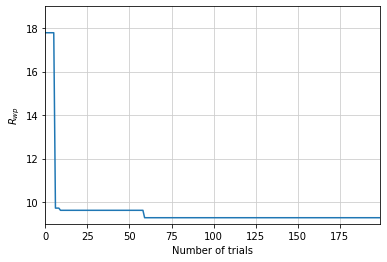

In [11]:
# Rwp plot
def rwp_plot():
    minvalues = [df.iloc[0]['Rwp']]
    for i in range(1, df.shape[0]):
        minvalues.append(min(minvalues[-1], df.iloc[i]['Rwp']))
    minvalues = pd.DataFrame(minvalues)
    
    minvalues.plot(legend=None)
    plt.ylim([9, 19])
    plt.grid(color='#cccccc')
    plt.ylabel('$R_{wp}$')
    plt.xlabel('Number of trials')
    plt.show()
    
rwp_plot()

GSAS-II binary directory: /opt/conda/GSASII/bindist


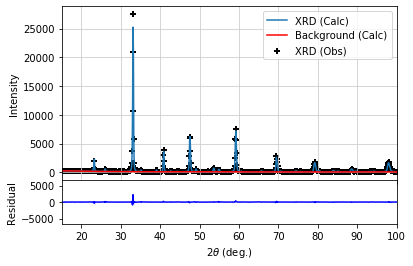

In [12]:
# Rietveld plot
def rietveld_plot():
    import GSASIIscriptable as G2sc

    gpx = G2sc.G2Project(
        '%s/%s_seed%s_trial_%s.gpx' % (WORK_DIR, STUDY_NAME, RANDOM_SEED, study.best_trial.number))

    hist1 = gpx.histograms()[0]
    phase0 = gpx.phases()[0]

    hist = hist1
    i = 5
    two_theta = hist.getdata("X")[::i]
    Yobs = hist.getdata("Yobs")[::i]
    Ycalc = hist.getdata("Ycalc")[::i]
    bg = hist.getdata("Background")[::i]
    residual = hist.getdata("Residual")[::i]

    fig = plt.figure()
    gs = GridSpec(5, 1, figure=fig)
    ax1 = fig.add_subplot(gs[:4, :])
    ax2 = fig.add_subplot(gs[4, :])
    fig.subplots_adjust(hspace=0)
    ax1.grid(color='#cccccc')

    ax1.scatter(two_theta, Yobs, marker='P', lw=0.0001, c='Black', label='XRD (Obs)')
    ax1.plot(two_theta, Ycalc, label='XRD (Calc)')
    ax1.plot(two_theta, bg, color='red', label='Background (Calc)')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    ax2.plot(two_theta, residual, color='blue')
    plt.setp(ax1.get_xticklabels(), visible=False);
    ax2.set_ylim(-6600, 6600)
    plt.xlabel(r'$2\theta$ (deg.)')
    ax2.set_ylabel('Residual')
    ax1.set_xlim(15, 100)
    ax2.set_xlim(15, 100)
    plt.show()
    
rietveld_plot()